# In-Context Learning Linear Regression -- Try One-Layer TF

**Authors: Xintian Pan, Jianliang He, Siyu Chen, Zhuoran Yang** 

**Note: Ongoing research. Do not distribute.**


This is the code for training one-layer Multi-Head SoftMax Attention to learn in-context linear regression tasks. The transformer model consists of only a single Multi-Head Attention layer. 

## TL;DR
In the experiment we discover that:
- **One-layer** Transformer learns kernel regressor algorithm by training
- **One-layer** Transformer with **2 softmax attention heads** learns **paired QK and OV circuits**
- When eigenvalues of the paired QK circuits are **small**, the output is close to the **one-step GD estimator**.
- **One-layer** Transformer with **more than 2 softmax attention heads** is equivalent to a one-layer Transformer with **2** heads
- **Multi-Head** SoftMax Attention **outperforms** one-head SoftMax Attention.

**Install necessary packages and check if we use GPU**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Optional
import numpy as np

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    device_message = f"GPU is available.\nUsing device: {device_name}"
else:
    device_message = "GPU is not available. Using CPU."
    
print(device_message)


seed = 1024
torch.manual_seed(seed)

# If you are using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

GPU is available.
Using device: NVIDIA GeForce RTX 4090


## Data Sampling Setting
Here we assume the input of data is structured as in-context example sequence $Z$ and query token $z_q$ where

$$
    Z = \begin{bmatrix}x_1 & x_2 & \dots & x_L \\ y_1 & y_2 & \dots &y_L\end{bmatrix}, z_q = \begin{bmatrix}x_q \\ 0\end{bmatrix}
$$

Where $x \in \mathbb{R}^d, y \in \mathbb{R}$.

Data is sampled by following step:
1. Sample $x_1,x_2,\dots,x_L\overset{\mathrm{i.i.d}}{\sim} \mathcal{N}(0, I_d), x_q \sim \mathcal{N}(0, I_d)$
2. Sample $\beta \sim \mathcal{N}(0, I_d)$
3. Sample $\epsilon_1,\epsilon_2,\dots,\epsilon_L\overset{\mathrm{i.i.d}}{\sim} \mathcal{N}(0, \sigma^2)$
4. $y_i = \beta^\top x_i + \epsilon_i, i \in [L]$

The following code imports the data generation process from utils/data_utils. 

In [2]:
from utils.data_utils import DataMethod, LinearReg

#### `DataMethod` Class:
- **Purpose**: Provides a base framework for data generation and transformation.
- **Methods**:
  - `__init__`: Initializes the class with an optional dictionary of parameters.
  - `__generatedata__`: Generates synthetic data with a specified sequence length and dimension. Returns a tensor filled with random values.
  - `__transform__`: Transforms input data by creating input-target pairs where the target is a shifted version of the input.

#### `LinearReg` Class:
- **Purpose**: Generates linear regression data based on specific parameters such as sequence length, noise level, and data size.
- **Attributes**:
  - `L`, `dx`, `dy`, `noise_std`, and `number_of_samples`: Parameters controlling data generation. (Note: Denote `noise_std` as `\delta`, then the variance for $\epsilon$ is $d \delta^2$ where $d$ denotes `dx`)
  - `G`: A matrix used for task-specific indexing.
- **Methods**:
  - `__init__`: Initializes parameters and creates the G matrix for task indexing.
  - `__generatedata__`: Generates input data, regression coefficients, and target outputs with noise. Concatenates data for use in regression tasks.
  - `__transform__`: Transforms input data, optionally zeroing out a specified index.

In our training setting, we have $L=8*d, \sigma^2=0.1$. We use a default batch size of $64$

In [3]:
# Define parameters
d = 5
bsize = 128
L = 8 * d

# Initialize the LinearReg object
train_method = LinearReg({
    "L": L,
    "dx": d,
    "dy": 1,
    "number_of_samples": bsize,
    "noise_std": np.sqrt(0.1)
})

# Generate data samples
z_q, z, y_q = train_method.__generatedata__()

# Print some samples from the generated data along with their dimensions
print("Sample data from the linear model:\n")

print("z (input and output concatenated):")
# print(z[:5])  # Print the first 5 samples
print(f"Dimensions of z: {z.shape}\n")

print("z_q (query data):")
print(z_q[:5])  # Print the first 5 query samples
print(f"Dimensions of z_q: {z_q.shape}\n")

print("y_q (query targets):")
print(y_q[:5])  # Print the first 5 query targets
print(f"Dimensions of y_q: {y_q.shape}\n")


Sample data from the linear model:

z (input and output concatenated):
Dimensions of z: torch.Size([128, 40, 6])

z_q (query data):
tensor([[[-1.0028,  0.5808, -0.0651,  0.5011,  1.9787,  0.0000]],

        [[ 1.5639,  0.4219, -1.3324, -0.0082,  0.0695,  0.0000]],

        [[-0.9833,  0.6277, -1.7880, -0.8808,  0.9120,  0.0000]],

        [[ 0.0654, -0.0865,  1.1273,  0.7868,  0.8076,  0.0000]],

        [[-0.3637, -2.0740,  0.6814, -0.7729,  0.8696,  0.0000]]])
Dimensions of z_q: torch.Size([128, 1, 6])

y_q (query targets):
tensor([[[-0.3784]],

        [[-0.4835]],

        [[ 2.0533]],

        [[-1.1917]],

        [[-0.4724]]])
Dimensions of y_q: torch.Size([128, 1, 1])



In this example, we set $d=5$, $L=8\cdot d$. So we want to predict $y_q$ given $x_q$ and $L$ additional $(x, y)$ pairs. 

## Model Class -- Single Layer Multi-Head Attention.

The code below defines the number of heads of the model. Suppose the number of head is $H$. Then the output of the model is
$$
    \mathtt{TF}_\theta(Z,z_q) = \sum_{h = 1}^HO^{(h)}V^{(h)}\mathtt{SoftMax}(\frac{Z^\top K^{(h)^\top}Q^{(h)}z_q}{\sqrt{d+1}})
$$

Here we have
$$
    Q^{(h)},K^{(h)},V^{(h)} \in \mathbb{R}^{(d+1)\times(d+1)}, O^{(h)} \in \mathbb{R}^{1\times(d+1)}
$$
The training loss is the least-squared loss: 
$$
   \ell(\theta) = \mathbb{E} \bigl [\bigl( \mathtt{TF}_\theta(Z,z_q)  -y_q \bigr)^2\bigr].
$$

**Further Explanation of Our Model**

The model is different from a default Multi-Head SoftMax Attention model because it only computes the output of the query token.

However, it is **equivalent** to a default Multi-Head SoftMax Attention model that calculates
$$
\mathtt{TF}^{'}_\theta(Z^{'}) = \sum_{h = 1}^H[O^{(h)}V^{(h)}\mathtt{SoftMax}(\frac{Z^{'^\top} K^{(h)^\top}Q^{(h)}Z^{'}}{\sqrt{d+1}} + M)]_q
$$

where 

$$
Z^{'} = [Z, z_q]
$$

and $M$ is mask matrix in $\mathbb{R}^{(d+1）\times(d+1)}$ where
$$
M_{ij} = 
\begin{cases}
    0,& \text{if } i \geqslant j\\
    -\infty,              & \text{otherwise}
\end{cases}
$$

so that token will attend to tokens strictly preceding it.

The subscript $q$ in $\mathtt{TF}_\theta(Z^{'})$ means we use query token $z_q$ position's output as the output of the model. And apply training loss to it, which the same as above.

The two variants are equivalent, we use the **first** to train our problem since we focus on **single layer** cases, but we also provide the **second** type of model to make it easier to stack as **multi layer** model.

**Note:** 
- We do not need to use positional embedding because it is okay to have permutation invariance (the first $L$ $(x,y)$ pairs are i.i.d.).
- We do not allow $z_q$ attend to itself.

We define the transformer architecture as follows. 

#### `MultiHeadAttention` Class

This class implements a custom multi-head attention mechanism with flexible initialization methods and optional bias handling for linear projections.

- **`__init__` Method**:
  - Initializes the class with configurable parameters:
    - `n_embd` (embedding dimension), `n_head` (number of heads), `init_method` (weight initialization strategy), `bias` (enable/disable bias), and `n_out` (optional output dimension).
  - Defines linear layers (`q_proj`, `k_proj`, `v_proj`, `o_proj`) for projecting queries, keys, values, and output.
  - Handles weight initialization based on the specified `init_method`:
    - **"random"**: Standard random initialization (default behavior).
    - **"small_id"**: Initializes the projection weights as small identity matrices for a more controlled initialization.
    - **"small_id_qk"**: Only initializes the query and key projections with small identity matrices.
    - **"oppo_small_id"**: Initializes half of the heads with a positive small identity matrix and the other half with a negative small identity matrix. This introduces diversity in the heads' initial states.

- **`_attn` Method**:
  - Implements the core attention mechanism using scaled dot-product attention:
    - **Inputs**:
      - `q` (queries), `k` (keys), and `v` (values) with shape `(batch_size, seq_len, n_head * n_embd)`.
    - **Reshaping**:
      - Splits and reshapes the inputs into separate heads.
    - **Attention Computation**:
      - Computes the attention scores using matrix multiplication, applies a scaling factor, and uses a softmax function to normalize the scores.
    - **Output**:
      - Computes the weighted sum of the values based on the attention weights.

- **`forward` Method**:
  - Defines the forward pass through the multi-head attention layer:
    - **Inputs**:
      - `z_q` (query input) with shape `(batch_size, 1, n_embd)` and `z` (key/value input) with shape `(batch_size, seq_len, n_embd)`.
    - **Projection**:
      - Projects the inputs to queries, keys, and values using the linear layers.
    - **Attention Computation**:
      - Calls the `_attn` method to compute attention outputs.
    - **Output Projection**:
      - Reshapes and projects the attention output to the desired output dimension.
    - **Optional Output**:
      - If `attention_out` is `True`, returns the attention weights as well.

- **`extract_qk` Method**:
  - Extracts the query and key weight matrices for each head, useful for analyzing or visualizing the learned attention patterns.

- **`extract_ov` Method**:
  - Extracts the output and value weight matrices for each head, providing insight into the learned transformations in the attention mechanism.


### Forward Function 

The forward function of the `MultiHeadAttention` module implements a series of linear transformations and scaled dot-product attention. Here's a breakdown of the mathematical equations representing its behavior:

Given:
- $ z_q \in \mathbb{R}^{B \times 1 \times d} $: Query input, where $ B $ is the batch size and $ d $ is the embedding dimension.
- $ z \in \mathbb{R}^{B \times S \times d} $: Key/Value input, where $ S $ is the sequence length.

### 1. Linear Projections
The input queries ($z_q$), keys ($ z $), and values ($ z $) are projected using linear layers:
\begin{align}
Q = z_q W_Q \in \mathbb{R}^{B \times 1 \times (h \cdot d_h)}, \quad
K = z W_K \in \mathbb{R}^{B \times S \times (h \cdot d_h)}, \quad 
V = z W_V \in \mathbb{R}^{B \times S \times (h \cdot d_h)}
\end{align}
where:
- $ W_Q, W_K, W_V \in \mathbb{R}^{d \times (h \cdot d_h)} $ are the projection matrices.
- $ h $ is the number of heads.
- $d_h = \frac{d}{h} $ is the dimension of each head.

### 2. Reshape and Permute
The projected queries, keys, and values are reshaped and permuted to split the heads:
\begin{align}
Q = \text{reshape}(Q) \in \mathbb{R}^{B \times h \times 1 \times d_h}, \quad 
K = \text{reshape}(K) \in \mathbb{R}^{B \times h \times S \times d_h}, \quad 
V = \text{reshape}(V) \in \mathbb{R}^{B \times h \times S \times d_h}
\end{align}

### 3. Scaled Dot-Product Attention
The attention scores are computed using scaled dot-product attention:
$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_h}} \right) V
$$
where:
- $ QK^T \in \mathbb{R}^{B \times h \times 1 \times S} $ represents the dot-product between queries and keys.
- The division by $ \sqrt{d_h} $ scales the dot-product values.
- The softmax operation normalizes the attention scores across the sequence dimension.

### 4. Concatenation of Heads
The outputs of the attention mechanism are concatenated:
$$
\text{Concat}(head_1, \ldots, head_h) \in \mathbb{R}^{B \times 1 \times (h \cdot d_h)}
$$

### 5. Final Linear Projection
The concatenated output is projected back to the output dimension:
$$
\text{Output} = \text{Concat}(head_1, \ldots, head_h) W_O \in \mathbb{R}^{B \times 1 \times d_{\text{out}}}
$$
where:
- $ W_O \in \mathbb{R}^{(h \cdot d_h) \times d_{\text{out}}}$ is the output projection matrix, and $ d_{\text{out}} $ is either $ d $ or a user-defined output dimension.

 
The overall equation for the forward function can be represented as:
$$
\text{Output} = \text{Concat} \left( \text{softmax} \left( \frac{QK^T}{\sqrt{d_h}} \right) V \right) W_O
$$
where:
- $ Q, K, V $ are the projected queries, keys, and values.
- The attention weights are computed as $ \text{softmax} \left( \frac{QK^T}{\sqrt{d_h}} \right)$.
- The output is obtained by concatenating the attention outputs from all heads and applying a final linear transformation.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head, init_method: str = "random", bias: bool = False, n_out: Optional[int] = None):
        '''
            Initialize the MultiHeadAttention module.
            Parameters:
                n_embd (int): Embedding dimension for the input.
                n_head (int): Number of attention heads.
                init_method (str): Method to initialize weights; options include:
                    - "random": Random initialization.
                    - "small_id": Initialize as a small identity matrix.
                    - "oppo_small_id": Initialize half heads with a positive small identity matrix, half with a negative small identity matrix.
                bias (bool): Whether to enable bias in the linear layers.
                n_out (int, optional): Output dimension. If None, the default dimension is n_embd.
        '''
        super(MultiHeadAttention, self).__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.bias = bias
        self.n_out = n_out

        # Define the linear projections for queries, keys, values, and output
        self.q_proj = nn.Linear(n_embd, n_embd * n_head, bias=self.bias)
        self.k_proj = nn.Linear(n_embd, n_embd * n_head, bias=self.bias)
        self.v_proj = nn.Linear(n_embd, n_embd * n_head, bias=self.bias)
        self.o_proj = nn.Linear(n_embd * n_head, n_embd, bias=self.bias) if self.n_out is None else nn.Linear(n_embd * n_head, n_out, bias=self.bias)

        # Handle different weight initialization strategies
        if init_method == "random":
            # Default random initialization; no additional action needed
            pass
        elif init_method == "small_id":
            # Initialize projections with a small identity matrix
            self.q_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-6
            self.k_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-6
            self.v_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-6
            if self.n_out is None:
                self.o_proj.weight.data = torch.eye(self.n_embd).repeat(1, self.n_head) * 1e-6
        elif init_method == "small_id_qk":
            # Initialize only the query and key projections as small identity matrices
            self.q_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-4
            self.k_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-4
        elif init_method == "oppo_small_id":
            # Initialize half heads with positive small identity and half with negative
            assert self.n_head % 2 == 0, "The number of heads must be divisible by 2 for 'oppo_small_id' initialization."
            positive_id = torch.eye(self.n_embd) * 1e-6
            negative_id = -torch.eye(self.n_embd) * 1e-6
            q_list = [positive_id for _ in range(self.n_head // 2)] + [negative_id for _ in range(self.n_head // 2)]
            q_tensor = torch.stack(q_list, dim=0).view(self.n_head * self.n_embd, self.n_embd)
            k_list = [positive_id for _ in range(self.n_head)]
            k_tensor = torch.stack(k_list, dim=0).view(self.n_head * self.n_embd, self.n_embd)
            self.q_proj.weight.data = q_tensor.clone()
            self.k_proj.weight.data = k_tensor.clone()
        else:
            raise NotImplementedError("Unsupported initialization method specified.")
        
    def _attn(self, q, k, v):
        '''
            Compute the attention mechanism.
            Parameters:
                q (torch.Tensor): Query tensor of shape (batch_size, seq_len, n_head * n_embd).
                k (torch.Tensor): Key tensor of the same shape as q.
                v (torch.Tensor): Value tensor of the same shape as q.
            Returns:
                attn_output (torch.Tensor): Output after applying attention.
                attn_weights (torch.Tensor): Attention weights.
        '''
        q_len = q.shape[1]
        ex_len = k.shape[1]
        # Reshape tensors to separate heads
        q = q.view(-1, q_len, self.n_head, self.n_embd)
        k = k.view(-1, ex_len, self.n_head, self.n_embd)
        v = v.view(-1, ex_len, self.n_head, self.n_embd)

        # Permute dimensions to prepare for attention computation
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        # Scaled dot-product attention
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.n_embd ** (-0.5)
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)  # Normalize attention weights

        # Apply attention weights to values
        attn_output = torch.matmul(attn_weights, v)
        return attn_output, attn_weights

    def forward(self, z_q, z):
        '''
            Forward pass through the multi-head attention layer.
            Parameters:
                z_q (torch.Tensor): Query input of shape (batch_size, 1, n_embd).
                z (torch.Tensor): Key/Value input of shape (batch_size, seq_len, n_embd).
               
            Returns:
                output (torch.Tensor): Attention output.
                
        '''
        batch_size, seq_len, q_len = z.size(0), z.size(1), z_q.size(1)
        q = self.q_proj(z_q)  # Project queries
        k = self.k_proj(z)    # Project keys
        v = self.v_proj(z)    # Project values

        # Compute attention
        attn_output, attn_weights = self._attn(q, k, v)

        # Reshape output to merge heads
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        attn_output = attn_output.view(batch_size, q_len, self.n_embd * self.n_head)
        output = self.o_proj(attn_output)  # Project to output space
        return output

    def extract_qk(self):
        '''
            Extract the query and key weight matrices for analysis.
            Returns:
                qk (list of dict): List containing query and key weight matrices for each head.
        '''
        q_matrix = self.q_proj.weight.detach().cpu().transpose(0, 1)
        k_matrix = self.k_proj.weight.detach().cpu().transpose(0, 1)
        q_matrix = q_matrix.view(self.n_embd, self.n_head, self.n_embd)
        k_matrix = k_matrix.view(self.n_embd, self.n_head, self.n_embd)

        qk = []
        for i in range(self.n_head):
            qk.append({'W_Q': q_matrix[:, i, :], 'W_K': k_matrix[:, i, :]})
        return qk

    def extract_ov(self):
        '''
            Extract the output and value weight matrices for analysis.
            Returns:
                ov (list of dict): List containing output and value weight matrices for each head.
        '''
        o_matrix = self.o_proj.weight.detach().cpu().transpose(0, 1)
        v_matrix = self.v_proj.weight.detach().cpu().transpose(0, 1)
        if self.n_out is None:
            o_matrix = o_matrix.view(self.n_head, self.n_embd, self.n_embd)
        else:
            o_matrix = o_matrix.view(self.n_head, self.n_embd, self.n_out)
        v_matrix = v_matrix.view(self.n_embd, self.n_head, self.n_embd)

        ov = []
        for i in range(self.n_head):
            ov.append({'W_O': o_matrix[i, :, :], 'W_V': v_matrix[:, i, :]})
        return ov

#### `CausalMultiHeadAttention` Class
The default Muti-Head Attention model with causal mask. It is can be used for multi-layer model. But it runs slower than `MultiHeadAttention` in **single layer** case.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CausalMultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head, init_method="random"):
        """
        Multi-layer causal multi-head attention mechanism.
        
        Parameters:
            n_embd (int): Embedding dimension for the input.
            n_head (int): Number of attention heads.
            num_layers (int): Number of layers in the attention stack.
        Output shape: 
        Batchsize * (Length+1) * (d+1)
        """
        super(CausalMultiHeadAttention, self).__init__()
        
        self.n_embd = n_embd
        self.n_head = n_head
        self.d_head = n_embd 
        self.n_out = n_embd
        
        # Define the linear projections for queries, keys, values, and output
        self.q_proj = nn.Linear(n_embd, n_embd * n_head, bias=None)
        self.k_proj = nn.Linear(n_embd, n_embd * n_head, bias=None)
        self.v_proj = nn.Linear(n_embd, n_embd * n_head, bias=None)
        self.o_proj = nn.Linear(n_embd * n_head, n_embd, bias=None)

        # buffer for causal masking
        self.register_buffer("bias", torch.tensor(-1e9))
    
    
        # Handle different weight initialization strategies
        if init_method == "random":
            # Default random initialization; no additional action needed
            pass
        elif init_method == "small_id":
            # Initialize projections with a small identity matrix
            self.q_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-6
            self.k_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-6
            self.v_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-6
            if self.n_out is None:
                self.o_proj.weight.data = torch.eye(self.n_embd).repeat(1, self.n_head) * 1e-6
        elif init_method == "small_id_qk":
            # Initialize only the query and key projections as small identity matrices
            self.q_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-4
            self.k_proj.weight.data = torch.eye(self.n_embd).repeat(self.n_head, 1) * 1e-4
        elif init_method == "oppo_small_id":
            # Initialize half heads with positive small identity and half with negative
            assert self.n_head % 2 == 0, "The number of heads must be divisible by 2 for 'oppo_small_id' initialization."
            positive_id = torch.eye(self.n_embd) * 1e-6
            negative_id = -torch.eye(self.n_embd) * 1e-6
            weights_list = [positive_id for _ in range(self.n_head // 2)] + [negative_id for _ in range(self.n_head // 2)]
            weights_tensor = torch.stack(weights_list, dim=0).view(self.n_head * self.n_embd, self.n_embd)
            self.q_proj.weight.data = weights_tensor.clone()
            self.k_proj.weight.data = weights_tensor.clone()
            self.v_proj.weight.data = weights_tensor.clone()
            weights_tensor_o = torch.cat(weights_list, dim=1)  # Shape: (n_embd, n_embd * n_head)
            self.o_proj.weight.data = weights_tensor_o.clone()
        else:
            raise NotImplementedError("Unsupported initialization method specified.")



    
    def forward(self, x):
        """
        Forward pass through the multi-layer attention mechanism with causal masking.
        
        Parameters:
            z_q (torch.Tensor): Query input of shape (batch_size, 1, n_embd).
            z (torch.Tensor): Key/Value input of shape (batch_size, L, n_embd).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, L+1, n_embd).
        """

        batch_size, seq_len, _ = x.size()

        # Project the input to get keys, queries, and values
        k = self.k_proj(x)  # Shape: (batch_size, seq_len, n_embd * n_head)
        q = self.q_proj(x)  # Shape: (batch_size, seq_len, n_embd * n_head)
        v = self.v_proj(x)  # Shape: (batch_size, seq_len, n_embd * n_head)
        
        # Reshape the tensors to separate heads
        k = k.view(batch_size, seq_len, self.n_head, self.d_head)  # Shape: (batch_size, seq_len, n_head, d_head)
        q = q.view(batch_size, seq_len, self.n_head, self.d_head)  # Shape: (batch_size, seq_len, n_head, d_head)
        v = v.view(batch_size, seq_len, self.n_head, self.d_head)  # Shape: (batch_size, seq_len, n_head, d_head)
        
        # Permute the dimensions to get (batch_size, n_head, seq_len, d_head)
        k = k.permute(0, 2, 1, 3)  # Shape: (batch_size, n_head, seq_len, d_head)
        q = q.permute(0, 2, 1, 3)  # Shape: (batch_size, n_head, seq_len, d_head)
        v = v.permute(0, 2, 1, 3)  # Shape: (batch_size, n_head, seq_len, d_head)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.n_embd ** (-0.5)
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)  # Normalize attention weights

        # Create causal mask, which strictly attends to previous token
        causal_mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=-1).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, seq_len)
        causal_mask = causal_mask.to(attn_weights.device)

        # Apply causal mask
        causal_mask = causal_mask.bool()
        attn_weights = torch.where(causal_mask, attn_weights, self.bias.to(attn_weights.dtype))

        # Caculate attention weights
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_output = torch.matmul(attn_weights, v)  # Shape: (batch_size, n_head, seq_len, d_head)
        
        # Apply attention weights to values
        attn_output = torch.matmul(attn_weights, v)  # Shape: (batch_size, n_head, seq_len, d_head)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()  # Shape: (batch_size, seq_len, n_head, d_head)
        attn_output = attn_output.view(batch_size, seq_len, self.n_head * self.d_head)  # Merge heads

        # Project the output
        output = self.o_proj(attn_output)  # Shape: (batch_size, seq_len, n_embd)
         
        return output


    def extract_qk(self):
        '''
            Extract the query and key weight matrices for analysis.
            Returns:
                qk (list of dict): List containing query and key weight matrices for each head.
        '''
        q_matrix = self.q_proj.weight.detach().cpu().transpose(0, 1)
        k_matrix = self.k_proj.weight.detach().cpu().transpose(0, 1)
        q_matrix = q_matrix.view(self.n_embd, self.n_head, self.n_embd)
        k_matrix = k_matrix.view(self.n_embd, self.n_head, self.n_embd)

        qk = []
        for i in range(self.n_head):
            qk.append({'W_Q': q_matrix[:, i, :], 'W_K': k_matrix[:, i, :]})
        return qk

    def extract_ov(self):
        '''
            Extract the output and value weight matrices for analysis.
            Returns:
                ov (list of dict): List containing output and value weight matrices for each head.
        '''
        o_matrix = self.o_proj.weight.detach().cpu().transpose(0, 1)
        v_matrix = self.v_proj.weight.detach().cpu().transpose(0, 1)
        if self.n_out is None:
            o_matrix = o_matrix.view(self.n_head, self.n_embd, self.n_embd)
        else:
            o_matrix = o_matrix.view(self.n_head, self.n_embd, self.n_out)
        v_matrix = v_matrix.view(self.n_embd, self.n_head, self.n_embd)

        ov = []
        for i in range(self.n_head):
            ov.append({'W_O': o_matrix[i, :, :], 'W_V': v_matrix[:, i, :]})

#### `MultiHeadAttentionStack` Class
This module implements that:
1. When using **single layer** model, use `MultiHeadAttention` to accerlerate computation
2. When using **multi layer** model, use `CausalMultiHeadAttention` as it is extensible to multi layers, while `MultiHeadAttention` is designed only for single layer
3. A uniform way to extract QK, OV circuits from the model

In [6]:
class MultiHeadAttentionStack(nn.Module):
    def __init__(self, n_layers, d_model, num_heads, n_out=1, weight_tying=False):
        """
        Stack multiple layers of attention mechanisms with optional weight tying.
        
        Parameters:
            n_layers (int): Number of attention layers.
            d_model (int): Embedding dimension.
            num_heads (int): Number of attention heads.
            n_out (int): Output dimension for the final linear transformation.
            weight_tying (bool): Whether to tie weights across all layers.
        """
        super(MultiHeadAttentionStack, self).__init__()
        self.n_layers = n_layers
        self.weight_tying = weight_tying
        self.d = d_model - 1
        
        if n_layers == 1:
            # Use the original MultiHeadAttention if there's only one layer
            self.attention_layer = MultiHeadAttention(d_model, num_heads, init_method="random", bias=False, n_out=n_out)
            self.is_single_layer = True
        else:
            self.is_single_layer = False
            if weight_tying:
                # Use a single shared instance of CausalMultiHeadAttention across all layers
                shared_attention_layer = CausalMultiHeadAttention(d_model, num_heads)
                self.attention_layers = nn.ModuleList([shared_attention_layer for _ in range(n_layers)])
            else:
                # Create independent instances of CausalMultiHeadAttention for each layer
                self.attention_layers = nn.ModuleList([CausalMultiHeadAttention(d_model, num_heads) for _ in range(n_layers)])
            self.final_linear = nn.Linear(d_model, n_out, bias=False)

    def forward(self, z_q, z):
        """
        Forward pass through the attention stack.
    
        Parameters:
            inputs (torch.Tensor): Input tensors.
                - Always expect (z_q, z) as inputs (query and key/value pair).
    
        Returns:
            torch.Tensor: Output tensor.
        """
        
    
        if self.is_single_layer:
            # For single-layer case, use the existing MultiHeadAttention logic
            return self.attention_layer(z_q, z)
        else:
            # For multi-layer case, combine z_q and z into one tensor along the sequence dimension
            x = torch.cat((z, z_q), dim=1)  # Shape: (batch_size, seq_len + 1, d_model)
            for layer in self.attention_layers:
                x = layer(x)
            
            # Apply final linear layer transformation
            output = self.final_linear(x)  # Shape: (batch_size, seq_len + 1, n_out)
    
            # Extract the output at the last position (corresponding to z_q)
            output = output[:, -1:, :]  # Shape: (batch_size, 1, n_out)
            return output

    def extract_qk_stack(self):
        """
        Extract the QK matrices for each layer in the stacked MultiHeadAttention model.
        
        Returns:
            list of list: Outer list corresponds to layers, and each inner list contains
                          QK matrices for each head in that layer.
        """
        if self.is_single_layer:
            return [self.attention_layer.extract_qk()]
        else:
            all_qk_matrices = []
            for layer in self.attention_layers:
                qk_matrices = layer.extract_qk()  # Call the extract_qk() method of CausalMultiHeadAttention
                all_qk_matrices.append(qk_matrices)
            return all_qk_matrices

    
    def extract_ov_stack(self):
        """
        Extract the OV matrices for each layer in the stacked MultiHeadAttention model.
        
        Returns:
            list of list: Outer list corresponds to layers, and each inner list contains
                          OV matrices for each head in that layer.
        """
        if self.is_single_layer:
            return [self.attention_layer.extract_ov()]
        else:
            all_ov_matrices = []
            for layer in self.attention_layers:
                ov_matrices = layer.extract_ov()  # Call the extract_ov() method of CausalMultiHeadAttention
                all_ov_matrices.append(ov_matrices)
            return all_ov_matrices

    def extract_final_linear(self):
        """
        Extract the parameters of the final linear layer in the attention stack.
        
        Returns:
            torch.nn.Parameter or None: If multi-layer, returns the parameter tensor of the final linear layer.
                                        If single-layer, prints a message and returns None.
        """
        if self.is_single_layer:
            
            return torch.eye(1).cpu()
        else:
            return self.final_linear.weight.detach().cpu()


# Define Methods to store QK/OV dynamics during training and plot trianing loss

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def QK_dyn_stack(model_stack):
    """
    Compute QK dynamics for each layer in a stacked MultiHeadAttention model.

    Parameters:
        model_stack (nn.Module): The stacked MultiHeadAttention model (instance of MultiHeadAttentionStack).

    Returns:
        list of list: QK dynamics for each layer, where each list corresponds to dynamics of all heads in a layer.
    """
    all_qk_dynamics = []
    d = model_stack.d  # Embedding dimension

    # Handle one-layer case
    if model_stack.n_layers == 1:
        qks = model_stack.attention_layer.extract_qk()
        qk_dynamics = []
        for qk in qks:
            W_Q = qk['W_Q']
            W_K = qk['W_K'].transpose(0, 1)
            W_QK = W_Q @ W_K
            diag_elements = torch.diagonal(W_QK)
            diag_elements_except_last = diag_elements[:-1]
            sum_diag = diag_elements_except_last.sum()
            qk_dynamics.append(sum_diag / (diag_elements_except_last.numel() * np.sqrt(d + 2)))
        all_qk_dynamics.append(qk_dynamics)
    else:
        # Handle multi-layer case
        for layer in model_stack.attention_layers:
            qks = layer.extract_qk()
            qk_dynamics = []
            for qk in qks:
                W_Q = qk['W_Q']
                W_K = qk['W_K'].transpose(0, 1)
                W_QK = W_Q @ W_K
                diag_elements = torch.diagonal(W_QK)
                diag_elements_except_last = diag_elements[:-1]
                sum_diag = diag_elements_except_last.sum()
                qk_dynamics.append(sum_diag / (diag_elements_except_last.numel() * np.sqrt(d + 2)))
            all_qk_dynamics.append(qk_dynamics)
    
    return all_qk_dynamics

def QK_mat_stack(model_stack):
    """
    Compute QK matrices for each layer in a stacked MultiHeadAttention model.

    Parameters:
        model_stack (nn.Module): The stacked MultiHeadAttention model (instance of MultiHeadAttentionStack).

    Returns:
        list of list: QK matrices for each layer, where each list corresponds to dynamics of all heads in a layer.
    """
    all_qk_matrices = []
    d = model_stack.d  # Embedding dimension

    # Handle one-layer case
    if model_stack.n_layers == 1:
        qks = model_stack.attention_layer.extract_qk()
        qk_matrices = []
        for qk in qks:
            W_Q = qk['W_Q']
            W_K = qk['W_K'].transpose(0, 1)
            W_QK = W_Q @ W_K
            qk_matrices.append(W_QK)
        all_qk_matrices.append(qk_matrices)
    else:
        # Handle multi-layer case
        for layer in model_stack.attention_layers:
            qks = layer.extract_qk()
            qk_dynamics = []
            for qk in qks:
                W_Q = qk['W_Q']
                W_K = qk['W_K'].transpose(0, 1)
                W_QK = W_Q @ W_K
                qk_matrices.append(W_QK)
            all_qk_matrices.append(qk_matrices)
    
    return all_qk_matrices



def OV_dyn_stack(model_stack):
    """
    Compute OV dynamics for each layer in a stacked MultiHeadAttention model.

    Parameters:
        model_stack (nn.Module): The stacked MultiHeadAttention model (instance of MultiHeadAttentionStack).

    Returns:
        list of list: OV dynamics for each layer, where each list corresponds to dynamics of all heads in a layer.
    """
    all_ov_dynamics = []

    # Handle one-layer case
    if model_stack.n_layers == 1:
        ovs = model_stack.attention_layer.extract_ov()
        ov_dynamics = []
        for ov in ovs:
            W_V = ov['W_V']
            W_O = ov['W_O']
            ov_circuit = W_V @ W_O
            ov_dynamics.append(ov_circuit[-1, 0])  # Assumes we're interested in this specific entry
        all_ov_dynamics.append(ov_dynamics)
    else:
        # Handle multi-layer case
        for layer in model_stack.attention_layers:
            ovs = layer.extract_ov()
            linear = model_stack.extract_final_linear()
            linear = linear.transpose(0, 1) 
            ov_dynamics = []
            for ov in ovs:
                W_V = ov['W_V']
                W_O = ov['W_O']
                ov_circuit = W_V @ W_O @ linear
                ov_dynamics.append(ov_circuit[-1, 0])  # Assumes we're interested in this specific entry
            all_ov_dynamics.append(ov_dynamics)
    
    return all_ov_dynamics



def plot_losses(training_losses, validation_losses, validation_every):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    plt.plot(range(len(training_losses)), training_losses, label="Training Loss")

    # Plot validation losses
    val_indices = list(range(0, len(training_losses), validation_every))
    plt.plot(val_indices, validation_losses, label="Validation Loss", linestyle="--")

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


# Define a Config Class that specify the configuration of model, training method, and data

In [8]:
class Config:
    def __init__(
        self, 
        n_layers=2, 
        n_head=1,
        n_out =1,
        d=5,
        weight_tying = False,
        L=None, 
        method='SGD', 
        learning_rate=0.001, 
        batch_size=128, 
        optimizer_params=None, 
        training_steps=100001, 
        dynamic_log_every_step=1000,
        qk_log_every_step=40000,
        loss_log_every_step=1000, 
        validation_every=1000, 
        print_loss_every=50000, 
        noise_std=0.01
    ):
        """
        Initialize the configuration for an experiment with default values.

        Parameters:
            n_layers (int): Number of MultiHeadAttention layers. Default is 2.
            n_head (int): Number of attention heads. Default is 1.
            d (int): Embedding dimension (embedding size will be d + 1). Default is 10.
            L (int, optional): Sequence length for data generation. Default is 8 * d.
            method (str): Optimization method ('SGD', 'Adam', 'AdamW'). Default is 'SGD'.
            learning_rate (float): Learning rate for optimization. Default is 0.001.
            batch_size (int): Batch size for training. Default is 128.
            optimizer_params (dict): Additional parameters for the optimizer. Default is None.
            training_steps (int): Total number of training steps. Default is 100001.
            dynamic_log_every_step (int): Interval for logging QK and OV dynamics. Default is 1000.
            qk_log_every_step (int): Interval for logging QK matrices. Default is 40000
            loss_log_every_step (int): Interval for logging loss. Default is 1000.
            validation_every (int): Interval for running validation. Default is 1000.
            print_loss_every (int): Interval for printing loss during validation. Default is 5000.
            noise_std (float): Standard deviation for noise in data generation. Default is 0.01.
        """
        self.n_layers = n_layers
        self.n_head = n_head
        self.d = d
        self.n_embd = d + 1  # Embedding dimension for the model is d + 1
        self.n_out = n_out
        self.weight_tying = weight_tying
        self.L = L if L is not None else 8 * d  # Default is 8 * d
        self.method = method
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.noise_std = noise_std
        
        self.optimizer_params = optimizer_params if optimizer_params is not None else {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0}
        self.training_steps = training_steps
        self.dynamic_log_every_step = dynamic_log_every_step
        self.qk_log_every_step = qk_log_every_step
        self.loss_log_every_step = loss_log_every_step
        self.validation_every = validation_every
        self.print_loss_every = print_loss_every

    def __repr__(self):
        return (f"Config(\n"
                f"  n_layers: {self.n_layers}\n"
                f"  n_head: {self.n_head}\n"
                f"  d: {self.d}\n"
                f"  L: {self.L}\n"
                f"  method: {self.method}\n"
                f"  learning_rate: {self.learning_rate}\n"
                f"  batch_size: {self.batch_size}\n"
                f"  noise_std: {self.noise_std}\n"
                f"  optimizer_params: {self.optimizer_params}\n"
                f"  training_steps: {self.training_steps}\n"
                f"  dynamic_log_every_step: {self.dynamic_log_every_step}\n"
                f"  qk_log_every_step: {self.qk_log_every_step}\n"
                f"  loss_log_every_step: {self.loss_log_every_step}\n"
                f"  validation_every: {self.validation_every}\n"
                f"  print_loss_every: {self.print_loss_every}\n"
                f"  n_embd (d + 1): {self.n_embd}\n"
                f")")


## Write the training and validation step


### Optimizer
 
We provide three optimizer options:
1. SGD (without momentum)
2. Adam
3. AdamW (Adam with weight decay regularization)

We only specify learning rate $\lambda$, which means only AdamW will use weight decay with default rate $0.001$.


### Training Setting

#### 1. Traning and Log Setup

Set Basic information for training logging.
1. `training_steps` defines the number of training steps
2. `dynamic_log_every_step` defines the frequency of logging the QK, OV dynamics of all heads.
3. `loss_log_every_step` defines the frequency of logging loss.

In [9]:
def train_step(model, z_q, z, y_q, optimizer, loss_func):
    optimizer.zero_grad()
    output = model(z_q, z)
    loss = loss_func(output, y_q)
    loss.backward()
    optimizer.step()
    return loss.detach().item(), output.detach()


def validate_step(model, z_q, z, y_q, loss_func):
    output = model(z_q, z)
    loss = loss_func(output, y_q)      
    return loss.detach().item()

## The whole pipeline 

In [10]:
from tqdm import tqdm

def run_experiment(config):
    """
    Run an experiment based on the given configuration.

    Parameters:
        config (Config): Configuration object containing experiment parameters.

    Returns:
        dict: Dictionary containing results of the experiment, including losses and dynamics.
    """
    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Instantiate the model
    model = MultiHeadAttentionStack(
        config.n_layers,
        config.n_embd,
        config.n_head,
        config.n_out,
        config.weight_tying
    )


    
    model.to(device)  # Move model to device

    # initialize data generation method
    data_generation = LinearReg({
        "L": config.L,
        "dx": config.d,
        "dy": 1,
        "number_of_samples": config.batch_size,
        "noise_std": config.noise_std
    })
    
    # Initialize optimizer
    optimizer_dict = {
        "SGD": torch.optim.SGD,
        "Adam": torch.optim.Adam,
        "AdamW": torch.optim.AdamW
    }
    optimizer = optimizer_dict[config.method](model.parameters(), lr=config.learning_rate, **config.optimizer_params)

    # Initialize loss function
    loss_func = torch.nn.MSELoss()

    # Initialize logging structures
    loss_sequence = []
    validation_loss_sequence = []

   # Correctly initialize data structures to store QK and OV dynamics and QK matrices
    if config.n_layers == 1:
        # For one-layer case, initialize lists for each head
        QK_dynamics = [[] for _ in range(config.n_head)]
        OV_dynamics = [[] for _ in range(config.n_head)]
        QK_matrices = [[] for _ in range(config.n_head)]
    else:
        # For multi-layer case, initialize lists for each layer and each head in the layer
        QK_dynamics = [[] for _ in range(config.n_layers)]  # Outer list for each layer
        OV_dynamics = [[] for _ in range(config.n_layers)]  # Outer list for each layer
        QK_matrices = [[] for _ in range(config.n_layers)]
        for layer_idx in range(config.n_layers):
            QK_dynamics[layer_idx] = [[] for _ in range(config.n_head)]
            OV_dynamics[layer_idx] = [[] for _ in range(config.n_head)]
            QK_matrices = [[] for _ in range(config.n_head)]


 
    # Training loop with tqdm for progress monitoring
  
    pbar = tqdm(range(config.training_steps))
    for step in pbar:
        # Generate training data
        zs_q, zs, ys_q = data_generation.__generatedata__()   
        
        loss, _ = train_step(model, zs_q.to(device), zs.to(device), ys_q.to(device), optimizer, loss_func)
        loss_sequence.append(loss)
    
        # Update progress bar description
        if step % config.loss_log_every_step == 0:
            pbar.set_description(f"Training loss {loss:.4f}")
    
        # Log QK and OV dynamics
        if step % config.dynamic_log_every_step == 0:
            qk_dynamics = QK_dyn_stack(model)  # Collect QK dynamics for all layers and heads
            ov_dynamics = OV_dyn_stack(model)  # Collect OV dynamics for all layers and heads
            
            if config.n_layers == 1:
                # Handle the one-layer case
                for head_idx in range(config.n_head):
                    QK_dynamics[head_idx].append(qk_dynamics[0][head_idx])  # qk_dynamics[0] since only one layer
                    OV_dynamics[head_idx].append(ov_dynamics[0][head_idx])  # ov_dynamics[0] since only one layer
            else:
                # Handle the multi-layer case
                for layer_idx in range(config.n_layers):
                    for head_idx in range(config.n_head):
                        QK_dynamics[layer_idx][head_idx].append(qk_dynamics[layer_idx][head_idx])
                        OV_dynamics[layer_idx][head_idx].append(ov_dynamics[layer_idx][head_idx])

        # Run validation
        if step % config.validation_every == 0:
            zs_q_val, zs_val, ys_q_val = data_generation.__generatedata__()  # Generate validation data
            val_loss = validate_step(model, zs_q_val.to(device), zs_val.to(device), ys_q_val.to(device), loss_func)
            validation_loss_sequence.append(val_loss)
            if step % config.print_loss_every == 0:
                print(f"After {step} steps, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Log QK matrices
        if step % config.qk_log_every_step == 0:
            qk_matrices = QK_mat_stack(model)
            if config.n_layers == 1:
                # Handle the one-layer case
                for head_idx in range(config.n_head):
                    QK_matrices[head_idx].append(qk_matrices[0][head_idx])  # qk_dynamics[0] since only one layer
            else:
                # Handle the multi-layer case
                for layer_idx in range(config.n_layers):
                    for head_idx in range(config.n_head):
                        QK_matrices[layer_idx][head_idx].append(qk_matrices[layer_idx][head_idx])


    return {
        'final_loss': loss,
        'training_losses': loss_sequence,
        'validation_losses': validation_loss_sequence,
        'qk_dynamics': QK_dynamics,
        'ov_dynamics': OV_dynamics,
        'qk_matrices': QK_matrices,
        'config': config,
        'model':model
    }


#### Run $H=4$

In [11]:
import random
import os

def set_seed(seed=217):
    """Set seed for reproducibility."""
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # PyTorch multi-GPU

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

n_layers, n_head, d= 1, 4, 5
config = Config(n_layers=n_layers, n_head=n_head, n_out=1, d=d, method='Adam', 
                  learning_rate=0.001, training_steps= 500001, batch_size=256, 
                  dynamic_log_every_step=1000, qk_log_every_step=10000, optimizer_params={}, noise_std=np.sqrt(0.1))
print(config)

# Create the "saved_models" directory if it doesn't exist
os.makedirs("saved_models", exist_ok=True)
# Save the model in the "saved_models" directory
model_path = f"saved_models/Layer_{n_layers}_Head_{n_head}_d_{d}_trained_model_0116.pth"

result = run_experiment(config)
saved_result = {
    'final_loss': result['final_loss'],
    'training_losses': result['training_losses'],
    'validation_losses': result['validation_losses'],
    'qk_dynamics': result['qk_dynamics'],
    'ov_dynamics': result['ov_dynamics'],
    'qk_matrices': result['qk_matrices'],
    'model': result['model'].state_dict()
}
torch.save(saved_result, model_path)

Config(
  n_layers: 1
  n_head: 4
  d: 5
  L: 40
  method: Adam
  learning_rate: 0.001
  batch_size: 256
  noise_std: 0.31622776601683794
  optimizer_params: {}
  training_steps: 500001
  dynamic_log_every_step: 1000
  qk_log_every_step: 10000
  loss_log_every_step: 1000
  validation_every: 1000
  print_loss_every: 50000
  n_embd (d + 1): 6
)
Using device: cuda


Training loss 1.1190:   0%|          | 36/500001 [00:00<1:08:16, 122.04it/s]

After 0 steps, Training Loss: 1.1190, Validation Loss: 0.9053


Training loss 0.2102:  10%|█         | 50109/500001 [01:33<13:33, 552.74it/s]

After 50000 steps, Training Loss: 0.2102, Validation Loss: 0.2036


Training loss 0.2193:  20%|██        | 100093/500001 [03:09<12:10, 547.21it/s]

After 100000 steps, Training Loss: 0.2193, Validation Loss: 0.2486


Training loss 0.2330:  30%|███       | 150068/500001 [04:56<10:39, 547.44it/s]

After 150000 steps, Training Loss: 0.2330, Validation Loss: 0.2743


Training loss 0.2189:  40%|████      | 200059/500001 [06:33<09:21, 534.10it/s]

After 200000 steps, Training Loss: 0.2189, Validation Loss: 0.2632


Training loss 0.2338:  50%|█████     | 250085/500001 [08:05<07:27, 558.93it/s]

After 250000 steps, Training Loss: 0.2338, Validation Loss: 0.2542


Training loss 0.2649:  60%|██████    | 300071/500001 [09:42<06:02, 550.80it/s]

After 300000 steps, Training Loss: 0.2649, Validation Loss: 0.2483


Training loss 0.2737:  70%|███████   | 350076/500001 [11:13<04:32, 550.27it/s]

After 350000 steps, Training Loss: 0.2737, Validation Loss: 0.3501


Training loss 0.2623:  80%|████████  | 400073/500001 [12:44<03:01, 550.65it/s]

After 400000 steps, Training Loss: 0.2623, Validation Loss: 0.2077


Training loss 0.3033:  90%|█████████ | 450104/500001 [14:15<01:31, 545.96it/s]

After 450000 steps, Training Loss: 0.3033, Validation Loss: 0.2350


Training loss 0.2334: 100%|██████████| 500001/500001 [15:54<00:00, 523.61it/s]


After 500000 steps, Training Loss: 0.2334, Validation Loss: 0.2393


## Visualization Setup

Import Visualization method

In [12]:
from utils.plot_utils import *

#### Visualize the Result for the pretrained model above

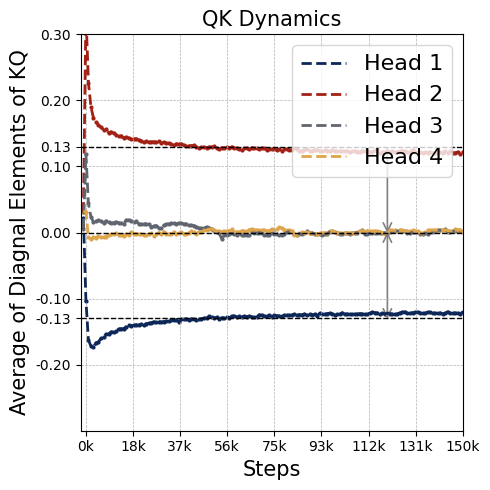

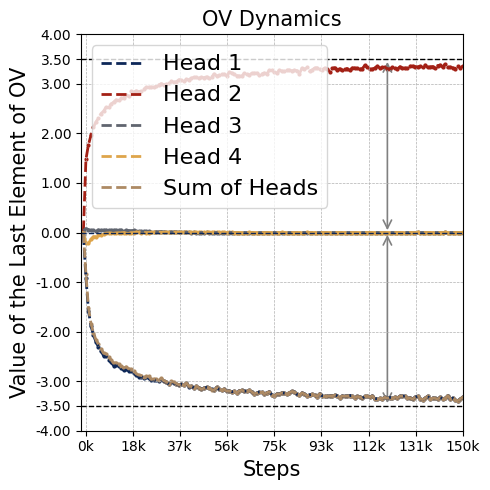

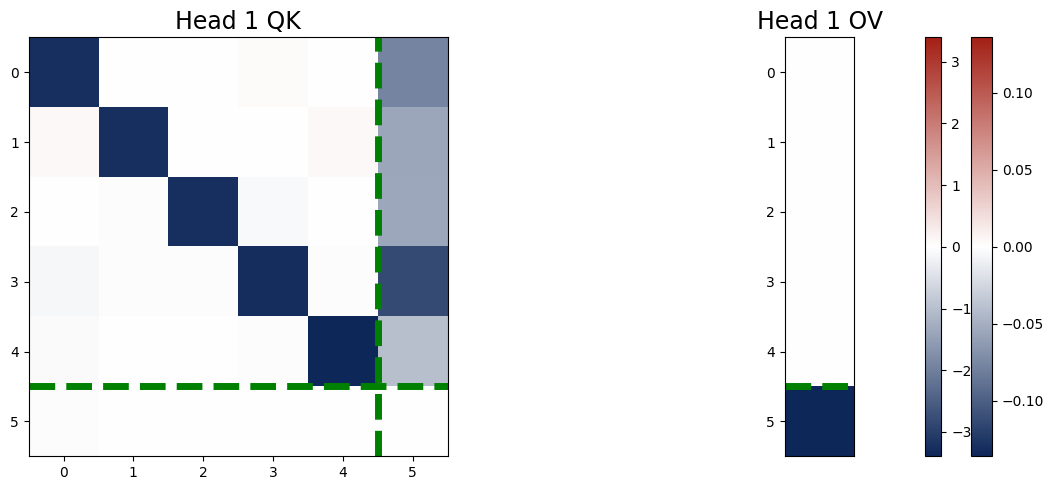

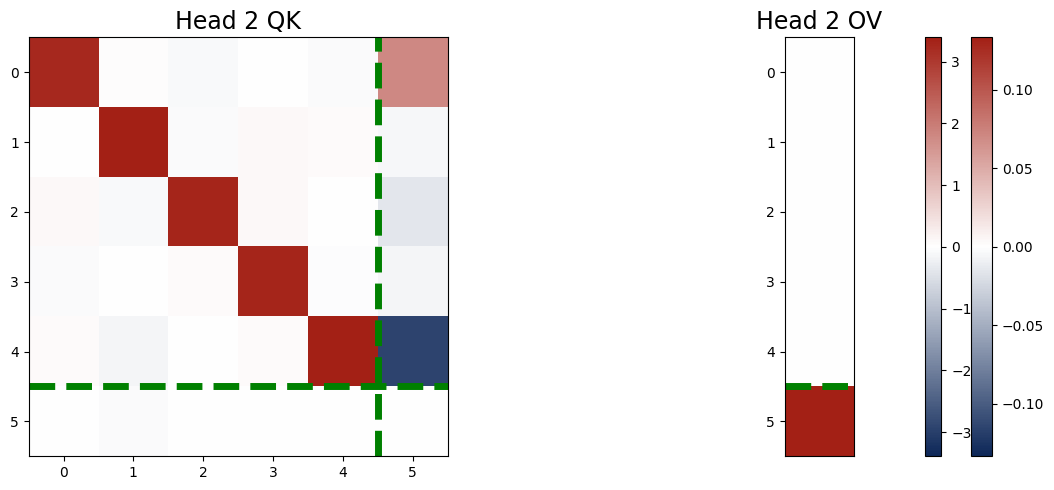

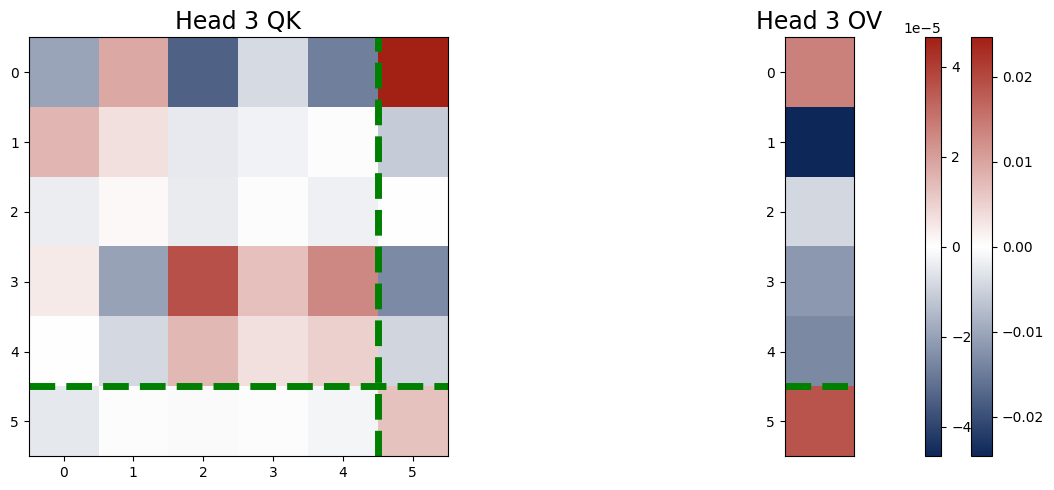

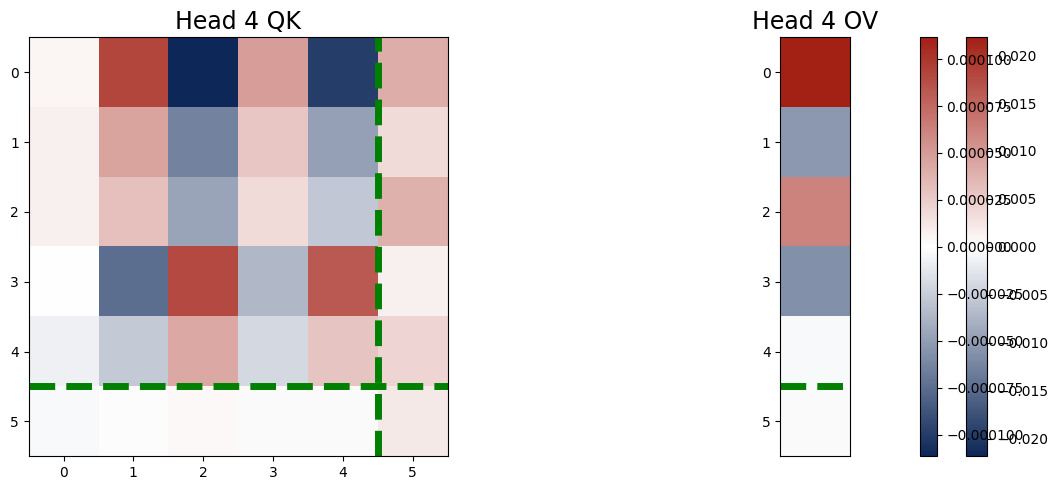

51


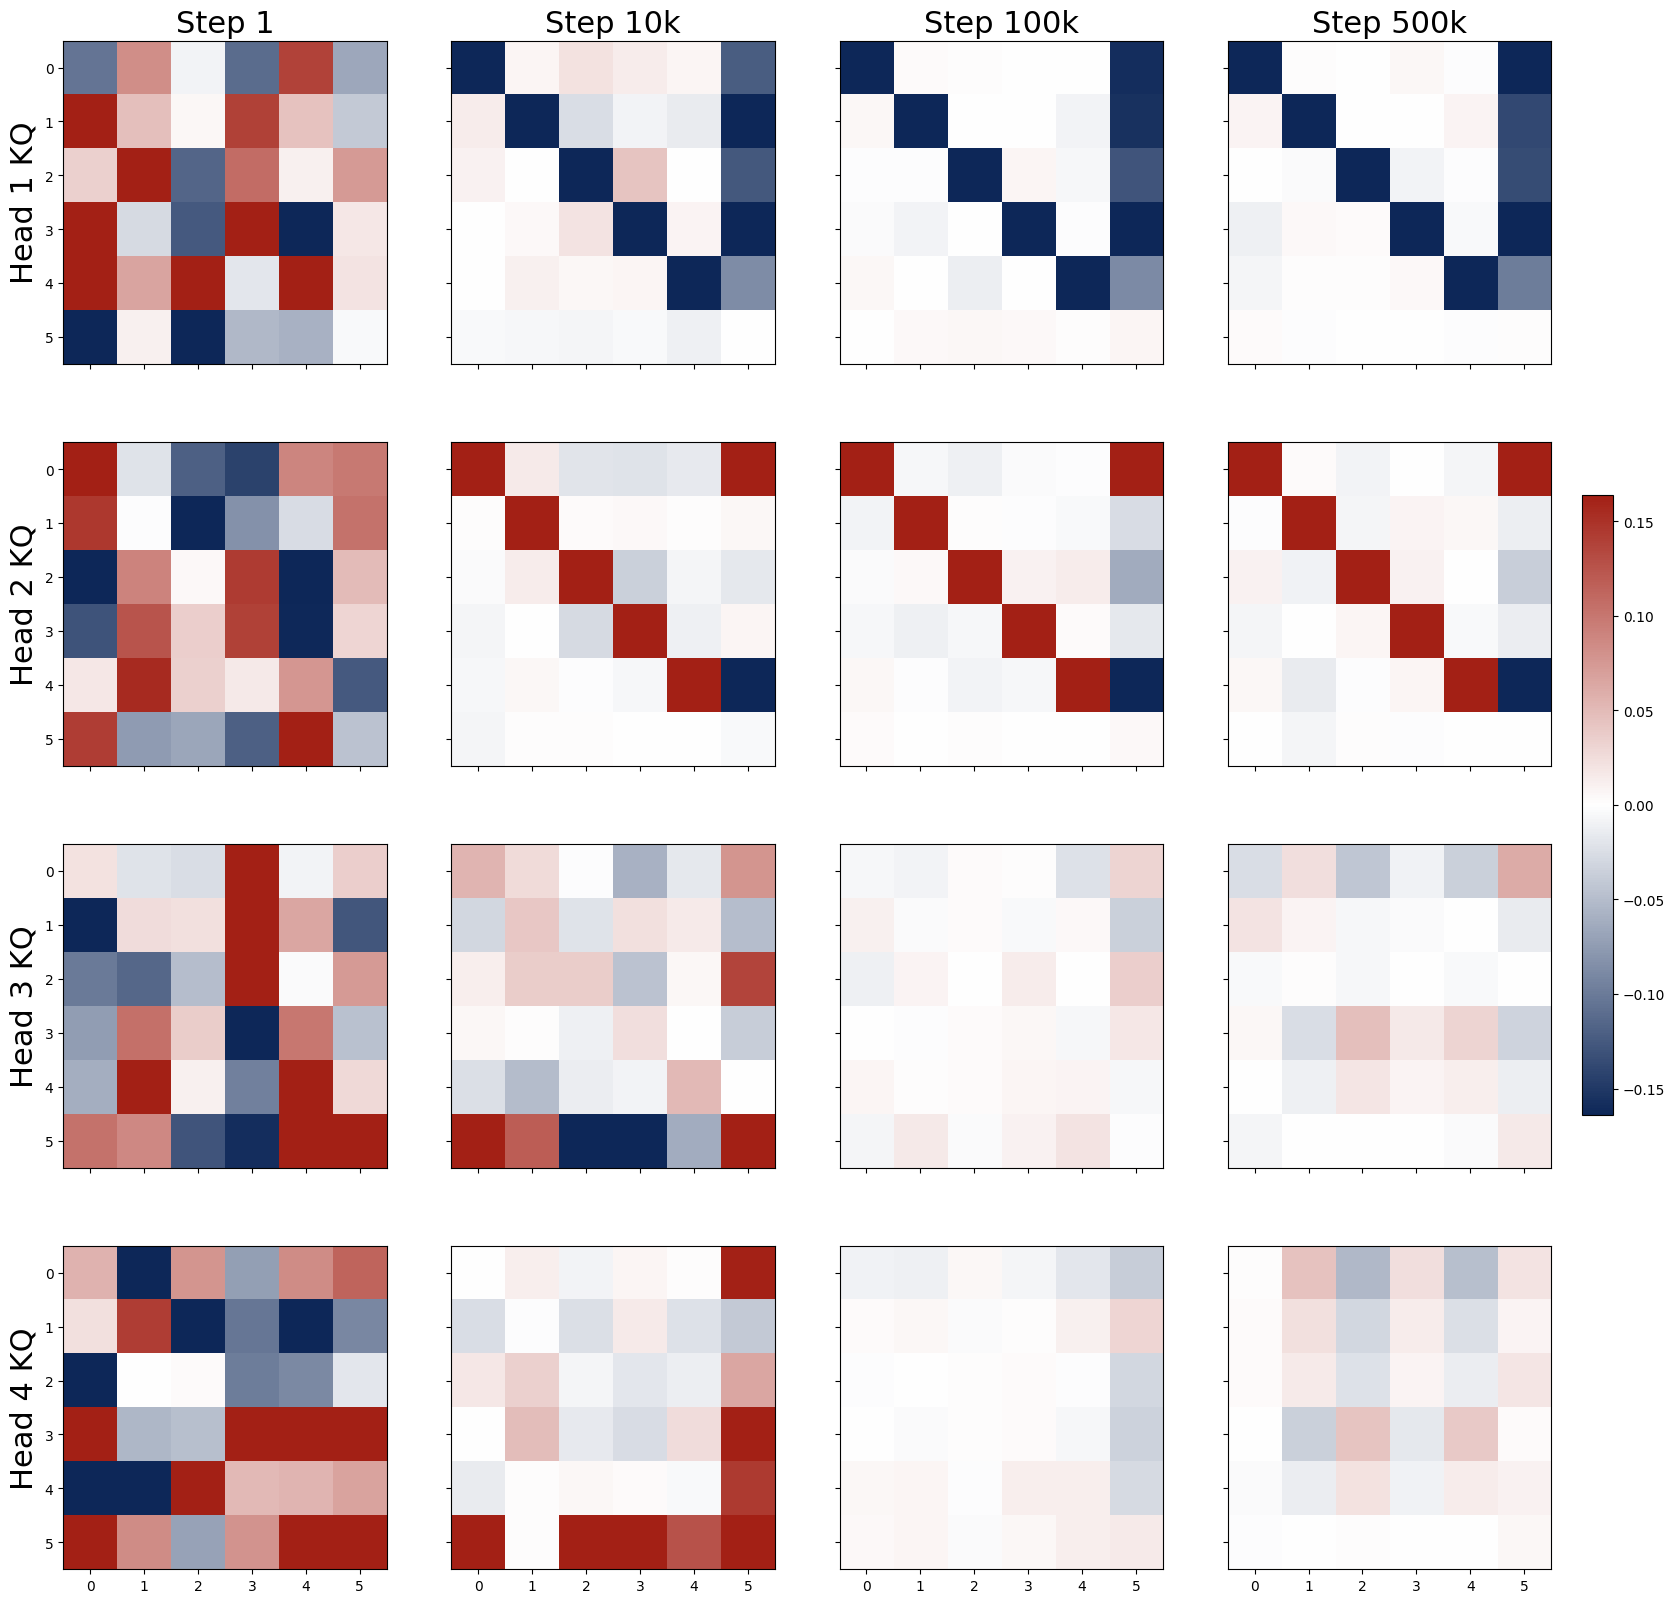

In [ ]:
# Extract components from result
config = result['config']
QK_dynamics = result['qk_dynamics']
OV_dynamics = result['ov_dynamics']
QK_matrices = result['qk_matrices']
model = result['model']

dynamic_log_every_step = config.dynamic_log_every_step
qk_log_every_step = config.qk_log_every_step
n_layers = config.n_layers
n_heads = config.n_head
d = config.d

# Plot dynamics
plot_4_head_dynamics(result, n_layers, n_heads, d)

# Plot QK and OV matrices for each layer
plot_attn_matrices(model.state_dict(), n_layers, d, n_heads)

# Plot evolution of QK matrices for each head

plot_heatmap_sequence_all_heads(n_layers, d, QK_matrices, [0,1,10,50], 500001, 0.35, False)


## Interpret the Results

We observe the following
-`QK circuits`: all close to a diagonal matrices, and the first $d$ diagonal elements are nonzero and roughly the same, and the $d+1$-th elements are almost zero.
-`OV circuits`: the first $d$ entries are almost zero, and the last entries are nonzero. 

Note: QK circuit is given by $W_Q^\top W_K /\sqrt{d+1}$.

# Key observation: Transformer learns a Kernel Estimator

So the learned transformer is determined by $2H$ numbers -- $\{ w^h, \mu^h\}_{h\in[H]}$. where $w^h$ is the diagonal element of the $h$-th QK circuit, and $\mu^h$ is the last entry of the $h$-th OV circuit. 

With this, we have a **closed-form** expression of the Transformer estimator: 
$$
\mathtt{TF}_\theta(Z,z_q) = \sum_{h = 1}^H \biggl[\mu^h \cdot \sum_{i=1}^L y_i \cdot \mathrm{Softmax}(x_q^\top x_i \cdot  w^h)\biggr], 
$$
which is a version of kernel estimator.

In [14]:
def kernel_estimator(z_q, Z, w_h_values, mu_h_values):
    """
    Compute the implemented kernel estimator given w_h and mu_h values.

    Parameters:`
        z_q (torch.Tensor): Query input of shape (batch_size, 1, d+1).
        Z (torch.Tensor): Combined Key/Value input of shape (batch_size, L, d+1) where each entry is (x_i, y_i).
        w_h_values (list): List of w^h values for each head.
        mu_h_values (list): List of mu^h values for each head.

    Returns:
        torch.Tensor: The estimated output of the Transformer.
    """
    H = len(w_h_values)  # Number of heads
    batch_size, L, d_plus_1 = Z.shape
    d = d_plus_1 - 1  # Extract d from d+1

    # Separate x and y components from Z
    x = Z[..., :d]  # Shape: (batch_size, L, d)
    y = Z[..., -1:]  # Shape: (batch_size, L, 1)

    # Extract x_q from z_q
    x_q = z_q[..., :d]  # Shape: (batch_size, 1, d)

    # Initialize the output tensor
    model_output = torch.zeros(batch_size, 1).to(Z.device)

    for h in range(H):
        w_h = w_h_values[h]
        mu_h = mu_h_values[h]

        # Compute dot products between x_q and x
        dot_products = torch.matmul(x_q, x.transpose(1, 2)) * w_h  # Shape: (batch_size, 1, L)
        # Compute softmax weights
        softmax_weights = F.softmax(dot_products, dim=-1)  # Shape: (batch_size, 1, L)

        # Compute the weighted sum of y values
        # Reshape softmax_weights to (batch_size, L, 1) for element-wise multiplication with y
        softmax_weights = softmax_weights.squeeze(1)  # Shape: (batch_size, L)
        weighted_sum = torch.sum(softmax_weights * y.squeeze(-1), dim=1, keepdim=True)  # Shape: (batch_size, 1)

        # Accumulate the result
        model_output += mu_h * weighted_sum  # Sum over heads

    return model_output


## Another observation: When QK eigenvalues are paired and small, the output is close to the one-step GD estimator. 

The following code implements the gradient estimator based on data. 


Given:
- Query vector $ x_q \in \mathbb{R}^{d}$ (extracted from `z_q`)
- Key-Value pairs $ (x_i, y_i) $ where $ x_i \in \mathbb{R}^{d} $ and $ y_i \in \mathbb{R} $ (extracted from `Z`)

The estimator computes the following sum:

$$
\text{Output} = \frac{1}{L} \sum_{i=1}^{L} y_i \cdot \langle x_i, x_q \rangle
$$

where:
- $\langle x_i, x_q \rangle$ denotes the dot product between the vectors $ x_i $ and $ x_q $.
- $ L $ is the number of key-value pairs.

In the code, this is achieved by:
1. Calculating the dot products between each $ x_i $ and $ x_q $.
2. Weighting each $ y_i $ by the corresponding dot product.
3. Summing the weighted terms across all $ i $.

In [15]:
def gradient_step_estimator(z_q, Z):
    """
    Compute a one-step gradient descent estimator.

    Parameters:
        z_q (torch.Tensor): Query input of shape (batch_size, 1, d+1).
        Z (torch.Tensor): Combined Key/Value input of shape (batch_size, L, d+1) where each entry is (x_i, y_i).

    Returns:
        torch.Tensor: The estimated output.
    """
    batch_size, L, d_plus_1 = Z.shape
    d = d_plus_1 - 1  # Extract d from d+1

    # Separate x and y components from Z
    x = Z[..., :d]  # Shape: (batch_size, L, d)
    y = Z[..., -1:]  # Shape: (batch_size, L, 1)

    # Extract x_q from z_q
    x_q = z_q[..., :d]  # Shape: (batch_size, 1, d)

    # Compute dot products between x and x_q
    dot_products = torch.bmm(x, x_q.transpose(1, 2)).squeeze(-1)  # Shape: (batch_size, L)

    # Compute the weighted sum of y values with the dot products
    weighted_sum = torch.sum(y.squeeze(-1) * dot_products, dim=1, keepdim=True) / L  # Shape: (batch_size, 1)

    return weighted_sum



def transformer_model(zs_q, zs, **kwargs):
    """
    Compute the output of a Transformer model.
    
    Parameters:
        zs_q (torch.Tensor): Query input.
        zs (torch.Tensor): Key/Value input.
        **kwargs: Additional arguments, including:
            model (nn.Module): The Transformer model to use.
    
    Returns:
        torch.Tensor: Output from the Transformer model.
    """
    model = kwargs.get('model')
    if model is None:
        raise ValueError("A 'model' argument must be provided.")
    
    model_output = model(zs_q, zs)  # Forward pass through the provided model
    return model_output.squeeze(-1)


# The following code evaluates the error of Transformer, kernel estimator, and one-step GD estimator

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def evaluate_errors(methods, method_names, loss_func, d, max_length=500, step=5):
    """
    Evaluate the error of multiple methods for varying L values and plot the error curves.

    Parameters:
        methods (list): List of methods (callable functions) to evaluate.
        method_names (list): List of names corresponding to the methods.
        loss_func (function): Loss function for evaluation.
        d (int): Embedding dimension.
        max_length (int): Maximum sequence length to evaluate. Default is 500.
        step (int): Step size for varying L. Default is 5.

    Returns:
        None
    """
    assert len(methods) == len(method_names), "The number of methods and method names must match."

    errors = {name: [] for name in method_names}  # Dictionary to store errors for each method

    for new_L in range(1, max_length + 1, step):
        # Generate new data with varying L
        evaluate_kernel_data = LinearReg({
            "L": new_L,
            "dx": d,
            "dy": 1,
            "number_of_samples": 100,
            "noise_std": 0.01
        })
        
        zs_q, zs, ys_q = evaluate_kernel_data.__generatedata__()
        zs_q, zs, ys_q = zs_q.cuda(), zs.cuda(), ys_q.cuda()

        # Evaluate each method
        for method, name in zip(methods, method_names):
            # Compute the output of the method
            method_output = method(zs_q, zs)

            # Compute the error
            error = loss_func(method_output, ys_q.squeeze(-1)).item()
            errors[name].append(error)

    # Plot the error curves
    plt.figure(figsize=(10, 6))
    for name in method_names:
        plt.plot(range(1, max_length + 1, step), errors[name], label=name)
    plt.xlabel("L (Sequence Length)")
    plt.ylabel("Error")
    plt.title("Error Curves for Different Methods")
    plt.legend()
    plt.grid(True)
    plt.show()


[-0.13930024, 0.1420475] [-3.171882, 3.1868296]


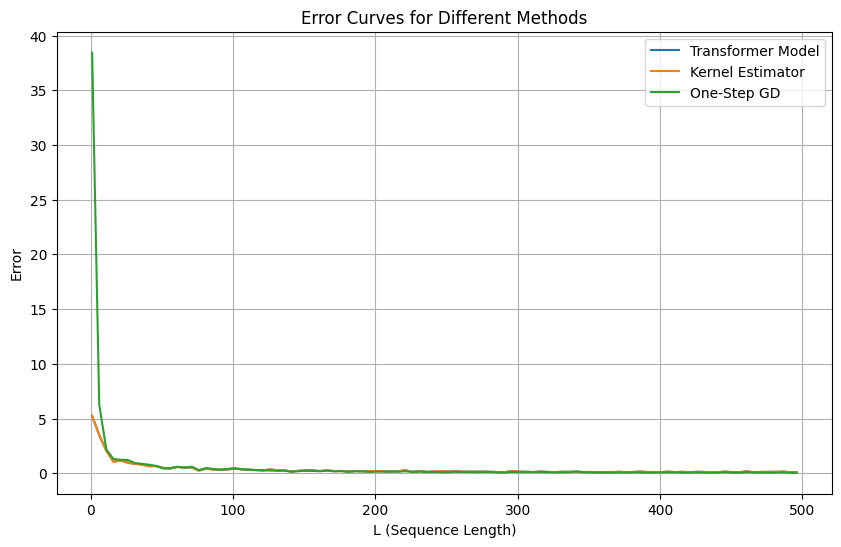

In [17]:
# Assuming `w_h_values` and `mu_h_values` are defined or will be provided
methods = [
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model),
    lambda zs_q, zs: kernel_estimator(zs_q, zs, **{'w_h_values': w_h_values, 'mu_h_values': mu_h_values}),
    gradient_step_estimator
]
method_names = ["Transformer Model", "Kernel Estimator", "One-Step GD"]


print(w_h_values, mu_h_values)


# Evaluate and plot errors
evaluate_errors(methods, method_names, loss_func=F.mse_loss, d=model.d)

# Further exploration on $H = 1, 4, 8$

In [18]:
# H = 1 case
config_2 = Config(n_layers=1, n_head=1, n_out=1, d=5, method='Adam', 
                  learning_rate=0.001, training_steps= 500001, batch_size=128, qk_log_every_step=1000)
# H = 3 case
config_3 = Config(n_layers=1, n_head=4, n_out=1, d=5, method='Adam', 
                  learning_rate=0.001, training_steps= 500001, batch_size=128, qk_log_every_step=1000)
# H = 4 case
config_4 = Config(n_layers=1, n_head=8, n_out=1, d=5, method='Adam', 
                  learning_rate=0.001, training_steps= 500001, batch_size=128, qk_log_every_step=1000)

configs = [config_2, config_3, config_4]

for config in configs:
    print(config)
    result = run_experiment(config)
    torch.save(result, f"Layer_{config.n_layers}_Head_{config.n_head}_d_{config.d}_trained_model.pth")
    results.append(result)

Config(
  n_layers: 1
  n_head: 1
  d: 5
  L: 40
  method: Adam
  learning_rate: 0.001
  batch_size: 128
  noise_std: 0.01
  optimizer_params: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0}
  training_steps: 500001
  dynamic_log_every_step: 1000
  qk_log_every_step: 1000
  loss_log_every_step: 1000
  validation_every: 1000
  print_loss_every: 50000
  n_embd (d + 1): 6
)
Using device: cuda


Training loss 3.9302:   0%|          | 89/500001 [00:00<09:25, 883.56it/s]

After 0 steps, Training Loss: 3.9302, Validation Loss: 6.2170


Training loss 2.4296:  10%|█         | 50156/500001 [00:54<08:09, 918.99it/s]

After 50000 steps, Training Loss: 2.4296, Validation Loss: 1.0964


Training loss 1.4892:  20%|██        | 100095/500001 [01:49<07:15, 917.86it/s]

After 100000 steps, Training Loss: 1.4892, Validation Loss: 1.0387


Training loss 1.7192:  30%|███       | 150109/500001 [02:43<06:22, 915.62it/s]

After 150000 steps, Training Loss: 1.7192, Validation Loss: 1.2786


Training loss 1.4605:  40%|████      | 200095/500001 [03:38<05:27, 914.43it/s]

After 200000 steps, Training Loss: 1.4605, Validation Loss: 1.3523


Training loss 1.6451:  50%|█████     | 250157/500001 [04:32<04:31, 918.76it/s]

After 250000 steps, Training Loss: 1.6451, Validation Loss: 1.4863


Training loss 1.1878:  60%|██████    | 300169/500001 [05:26<03:37, 920.35it/s]

After 300000 steps, Training Loss: 1.1878, Validation Loss: 0.9685


Training loss 1.1988:  70%|███████   | 350103/500001 [06:21<02:42, 923.25it/s]

After 350000 steps, Training Loss: 1.1988, Validation Loss: 1.8529


Training loss 1.6569:  80%|████████  | 400125/500001 [07:15<01:48, 923.28it/s]

After 400000 steps, Training Loss: 1.6569, Validation Loss: 1.4626


Training loss 1.4484:  90%|█████████ | 450156/500001 [08:09<00:54, 920.31it/s]

After 450000 steps, Training Loss: 1.4484, Validation Loss: 1.1815


Training loss 1.2700: 100%|██████████| 500001/500001 [09:03<00:00, 919.88it/s]


After 500000 steps, Training Loss: 1.2700, Validation Loss: 1.2510
Config(
  n_layers: 1
  n_head: 4
  d: 5
  L: 40
  method: Adam
  learning_rate: 0.001
  batch_size: 128
  noise_std: 0.01
  optimizer_params: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0}
  training_steps: 500001
  dynamic_log_every_step: 1000
  qk_log_every_step: 1000
  loss_log_every_step: 1000
  validation_every: 1000
  print_loss_every: 50000
  n_embd (d + 1): 6
)
Using device: cuda


Training loss 5.6028:   0%|          | 0/500001 [00:00<?, ?it/s]

After 0 steps, Training Loss: 5.6028, Validation Loss: 5.4725


Training loss 0.8057:  10%|█         | 50175/500001 [00:55<08:21, 896.29it/s]

After 50000 steps, Training Loss: 0.8057, Validation Loss: 0.7758


Training loss 0.6898:  20%|██        | 100142/500001 [01:51<07:25, 898.19it/s]

After 100000 steps, Training Loss: 0.6898, Validation Loss: 0.5748


Training loss 0.7836:  30%|███       | 150163/500001 [02:47<06:30, 896.53it/s]

After 150000 steps, Training Loss: 0.7836, Validation Loss: 0.5909


Training loss 0.4195:  40%|████      | 200052/500001 [03:43<07:28, 668.74it/s]

After 200000 steps, Training Loss: 0.4195, Validation Loss: 0.6980


Training loss 0.8475:  50%|█████     | 250091/500001 [04:39<04:39, 894.51it/s]

After 250000 steps, Training Loss: 0.8475, Validation Loss: 0.7573


Training loss 0.8310:  60%|██████    | 300176/500001 [05:35<03:41, 902.65it/s]

After 300000 steps, Training Loss: 0.8310, Validation Loss: 0.6597


Training loss 0.5963:  70%|███████   | 350132/500001 [06:30<02:46, 902.46it/s]

After 350000 steps, Training Loss: 0.5963, Validation Loss: 0.6835


Training loss 0.4826:  80%|████████  | 400093/500001 [07:25<01:51, 899.52it/s]

After 400000 steps, Training Loss: 0.4826, Validation Loss: 0.5635


Training loss 0.6566:  90%|█████████ | 450099/500001 [08:21<00:55, 897.67it/s]

After 450000 steps, Training Loss: 0.6566, Validation Loss: 0.6471


Training loss 0.7853: 100%|██████████| 500001/500001 [09:16<00:00, 897.78it/s]


After 500000 steps, Training Loss: 0.7853, Validation Loss: 0.6087
Config(
  n_layers: 1
  n_head: 8
  d: 5
  L: 40
  method: Adam
  learning_rate: 0.001
  batch_size: 128
  noise_std: 0.01
  optimizer_params: {'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0}
  training_steps: 500001
  dynamic_log_every_step: 1000
  qk_log_every_step: 1000
  loss_log_every_step: 1000
  validation_every: 1000
  print_loss_every: 50000
  n_embd (d + 1): 6
)
Using device: cuda


Training loss 3.8172:   0%|          | 0/500001 [00:00<?, ?it/s]

After 0 steps, Training Loss: 3.8172, Validation Loss: 4.7141


Training loss 0.5492:  10%|█         | 50116/500001 [00:55<08:22, 895.10it/s]

After 50000 steps, Training Loss: 0.5492, Validation Loss: 0.6048


Training loss 0.7861:  20%|██        | 100105/500001 [01:51<07:23, 901.20it/s]

After 100000 steps, Training Loss: 0.7861, Validation Loss: 0.5863


Training loss 0.4775:  30%|███       | 150179/500001 [02:47<06:33, 889.67it/s]

After 150000 steps, Training Loss: 0.4775, Validation Loss: 0.6911


Training loss 0.5935:  40%|████      | 200136/500001 [03:42<05:34, 896.19it/s]

After 200000 steps, Training Loss: 0.5935, Validation Loss: 0.7361


Training loss 0.5215:  50%|█████     | 250161/500001 [04:38<04:38, 895.81it/s]

After 250000 steps, Training Loss: 0.5215, Validation Loss: 0.6961


Training loss 0.6735:  60%|██████    | 300173/500001 [05:34<03:43, 895.47it/s]

After 300000 steps, Training Loss: 0.6735, Validation Loss: 0.8214


Training loss 0.7430:  70%|███████   | 350107/500001 [06:30<02:47, 894.03it/s]

After 350000 steps, Training Loss: 0.7430, Validation Loss: 0.5388


Training loss 0.5937:  80%|████████  | 400091/500001 [07:26<01:53, 881.66it/s]

After 400000 steps, Training Loss: 0.5937, Validation Loss: 0.9120


Training loss 0.7102:  90%|█████████ | 450124/500001 [08:22<00:55, 897.18it/s]

After 450000 steps, Training Loss: 0.7102, Validation Loss: 1.0240


Training loss 0.5503: 100%|██████████| 500001/500001 [09:18<00:00, 895.95it/s]


After 500000 steps, Training Loss: 0.5503, Validation Loss: 0.7719


#### Visualize $H=1$

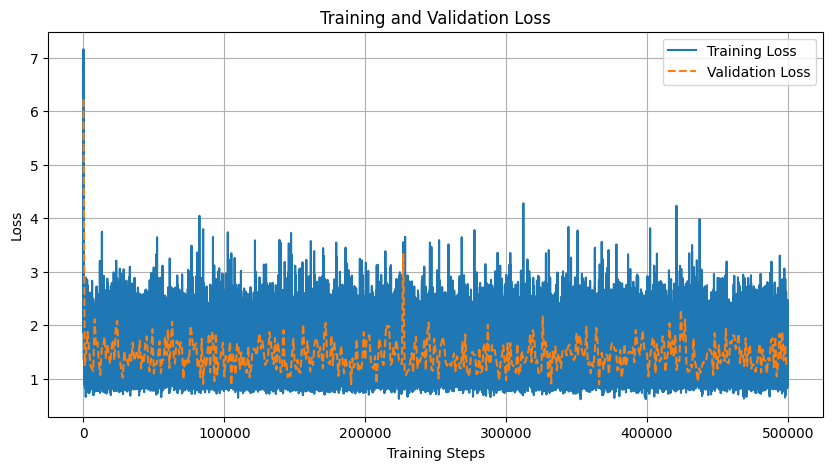

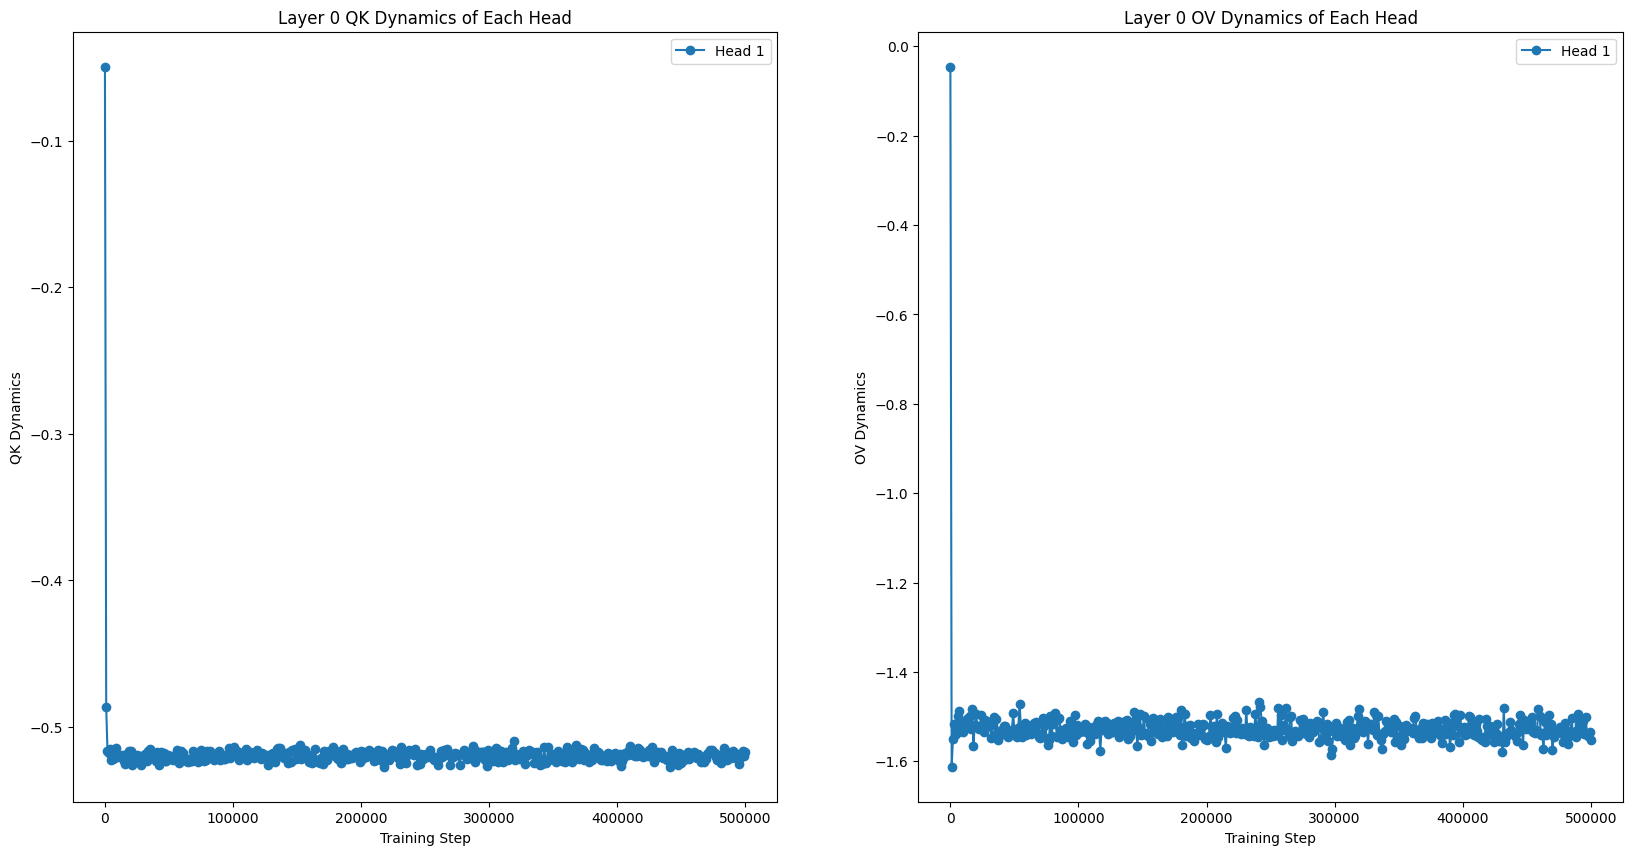

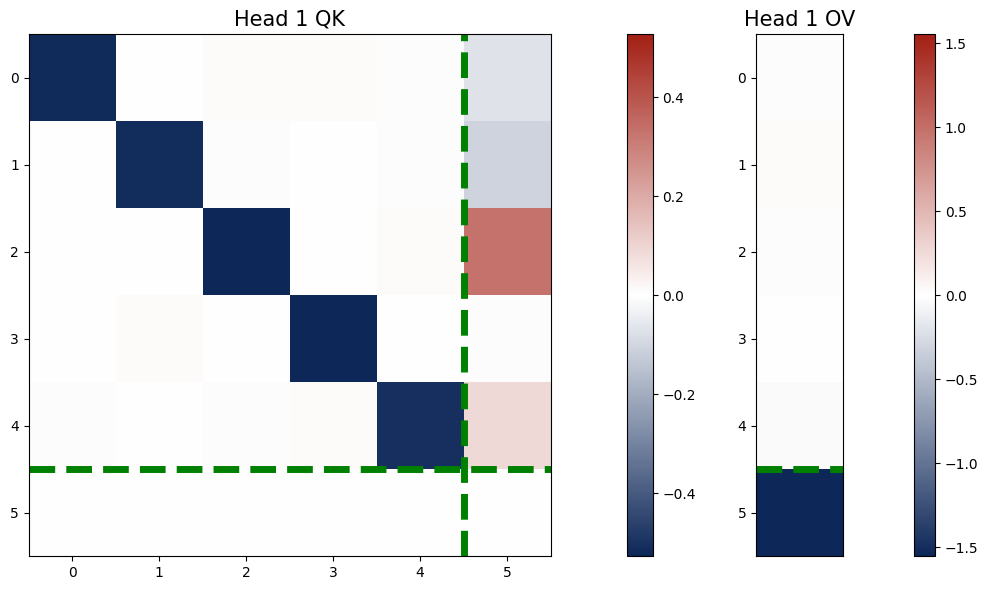

1 501


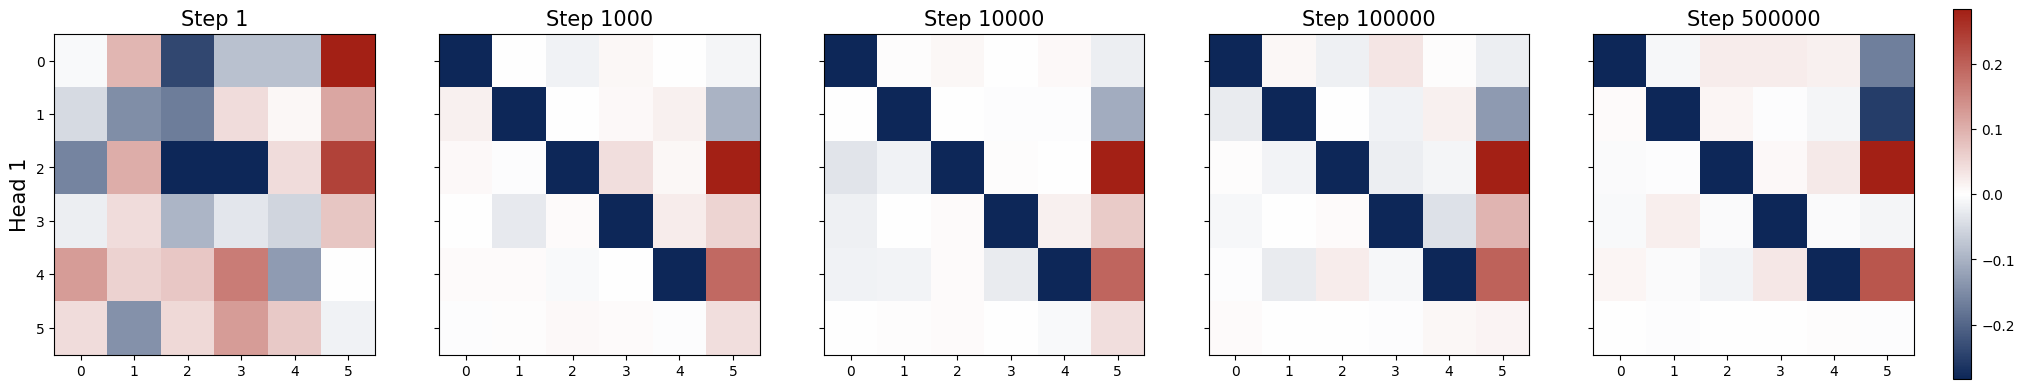

Layer 0, Head 0: w^h = -0.5177, variance of first 5 diagonal elements = 0.0001, sup-norm of rest of d x d block entries = 0.0122
Layer 0, Head 0: mu^h = -1.5523, sup-norm of rest of OV entries = 0.0330

Summary of w^h and mu^h for each head:
Head 0: mu^h = -1.5523, w^h = -0.5177

Hypothesized value of w^h: 1/sqrt(d) = 0.4472


In [19]:
result = results[1]

plot_losses(result['training_losses'], result['validation_losses'], result['config'].validation_every)

# Extract components from result
config = result['config']
QK_dynamics = result['qk_dynamics']
OV_dynamics = result['ov_dynamics']
QK_matrices = result['qk_matrices']
model = result['model']

dynamic_log_every_step = config.dynamic_log_every_step
qk_log_every_step = config.qk_log_every_step
n_layers = config.n_layers
n_heads = config.n_head
d = config.d

# Plot dynamics
plot_dynamics(QK_dynamics, OV_dynamics, dynamic_log_every_step, n_layers, n_heads)

# Plot QK and OV matrices for each layer
plot_attn_matrices(model.state_dict(), n_layers, d, n_heads, False)

# Plot evolution of QK matrices for each head
plot_heatmap_sequence_all_heads(QK_matrices, [0,1,10,100,500], 500000, 0.35, False)

# Calculate and print statistics
w_h_values, mu_h_values = calculate_statistics(model, d)

[-0.51768464] [-1.5523255]


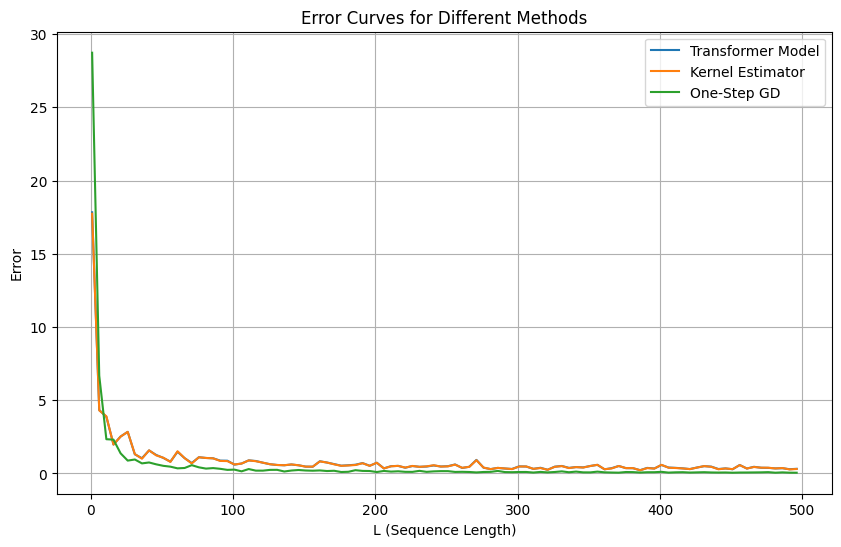

In [20]:
# Assuming `w_h_values` and `mu_h_values` are defined or will be provided
methods = [
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model),
    lambda zs_q, zs: kernel_estimator(zs_q, zs, **{'w_h_values': w_h_values, 'mu_h_values': mu_h_values}),
    gradient_step_estimator
]
method_names = ["Transformer Model", "Kernel Estimator", "One-Step GD"]


print(w_h_values, mu_h_values)


# Evaluate and plot errors
evaluate_errors(methods, method_names, loss_func=F.mse_loss, d=model.d)

#### Visualize $H=4$

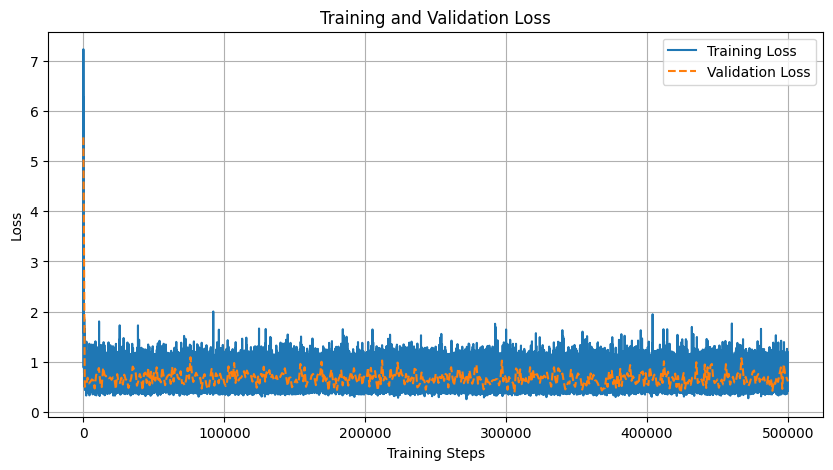

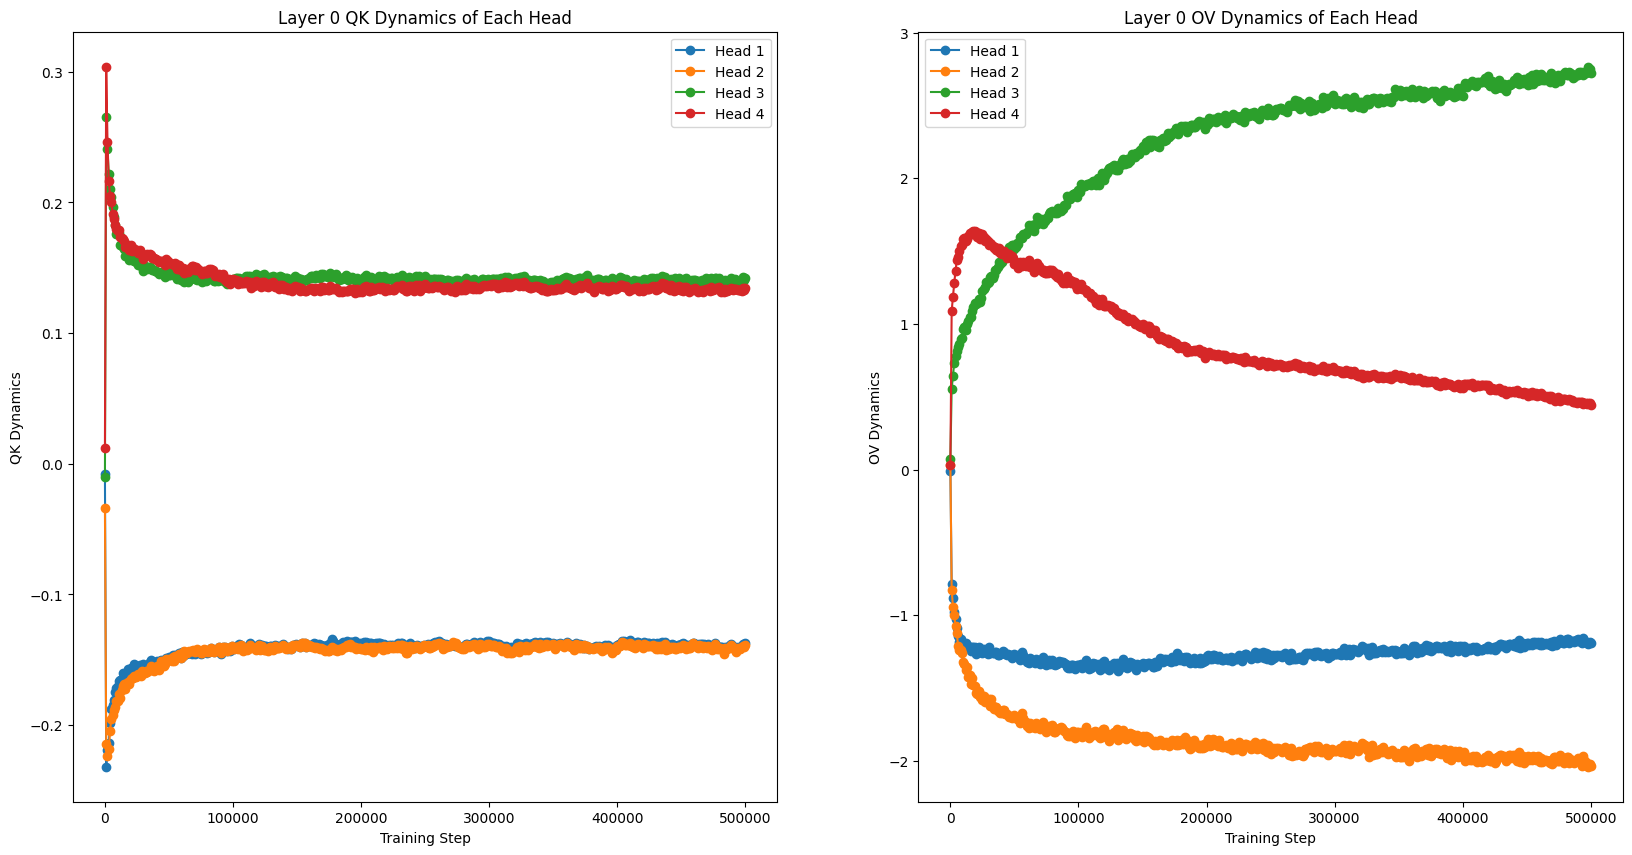

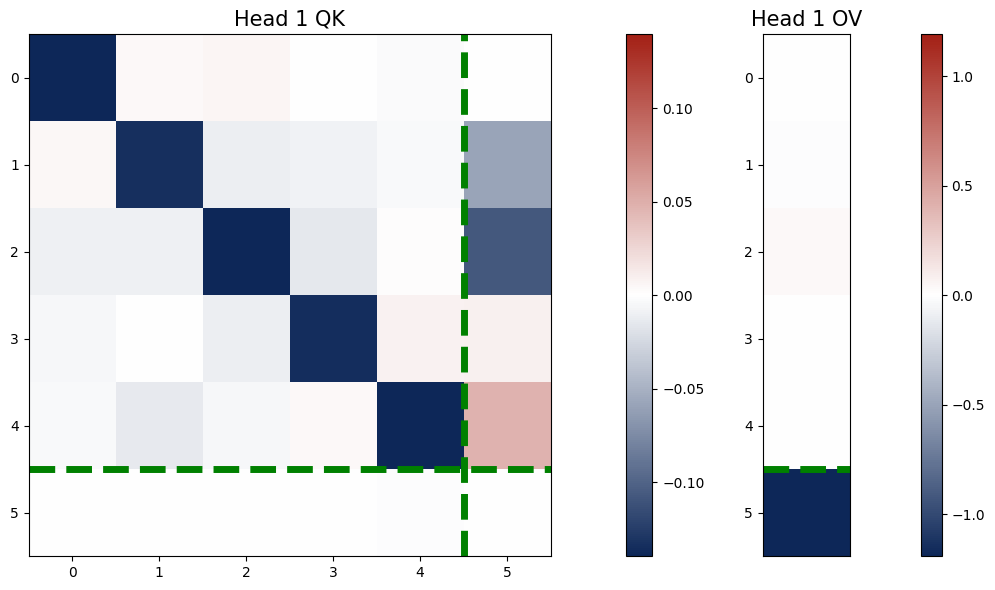

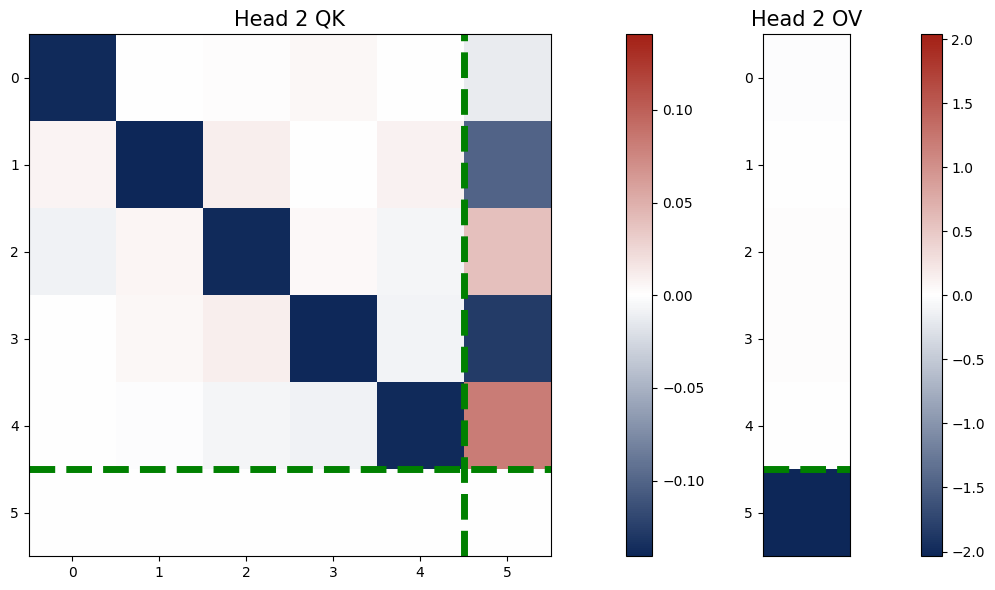

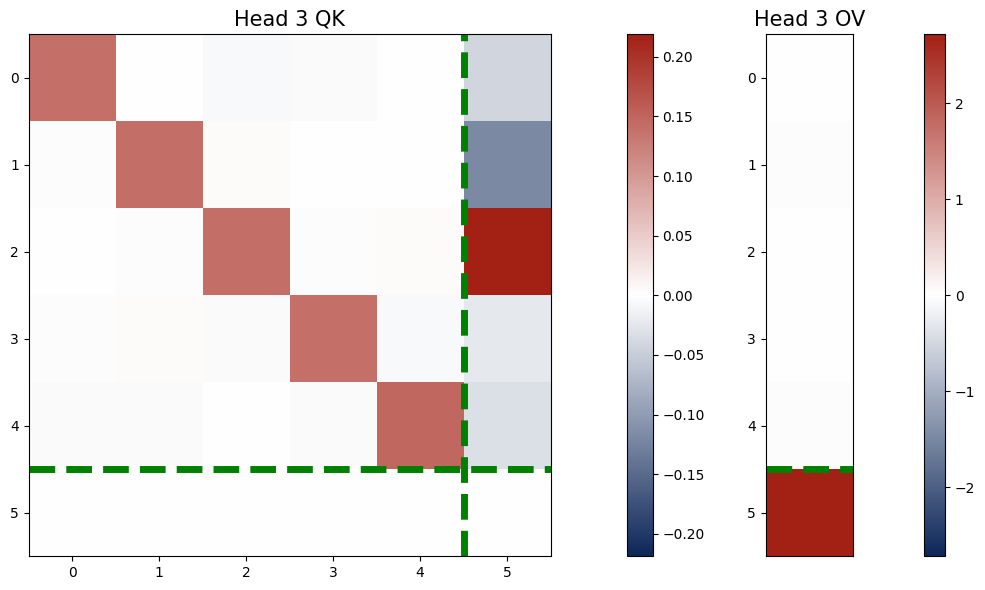

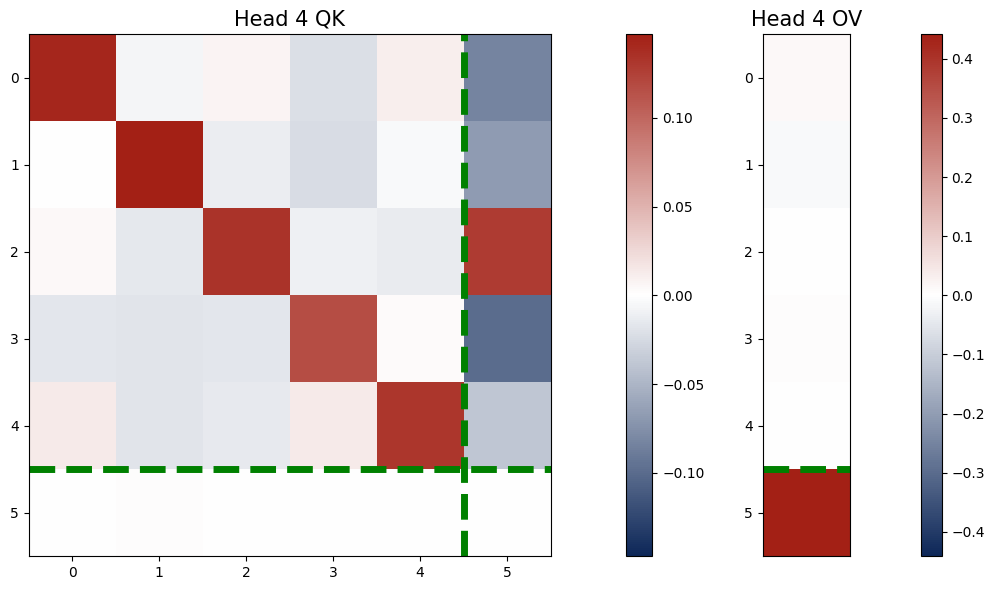

4 501


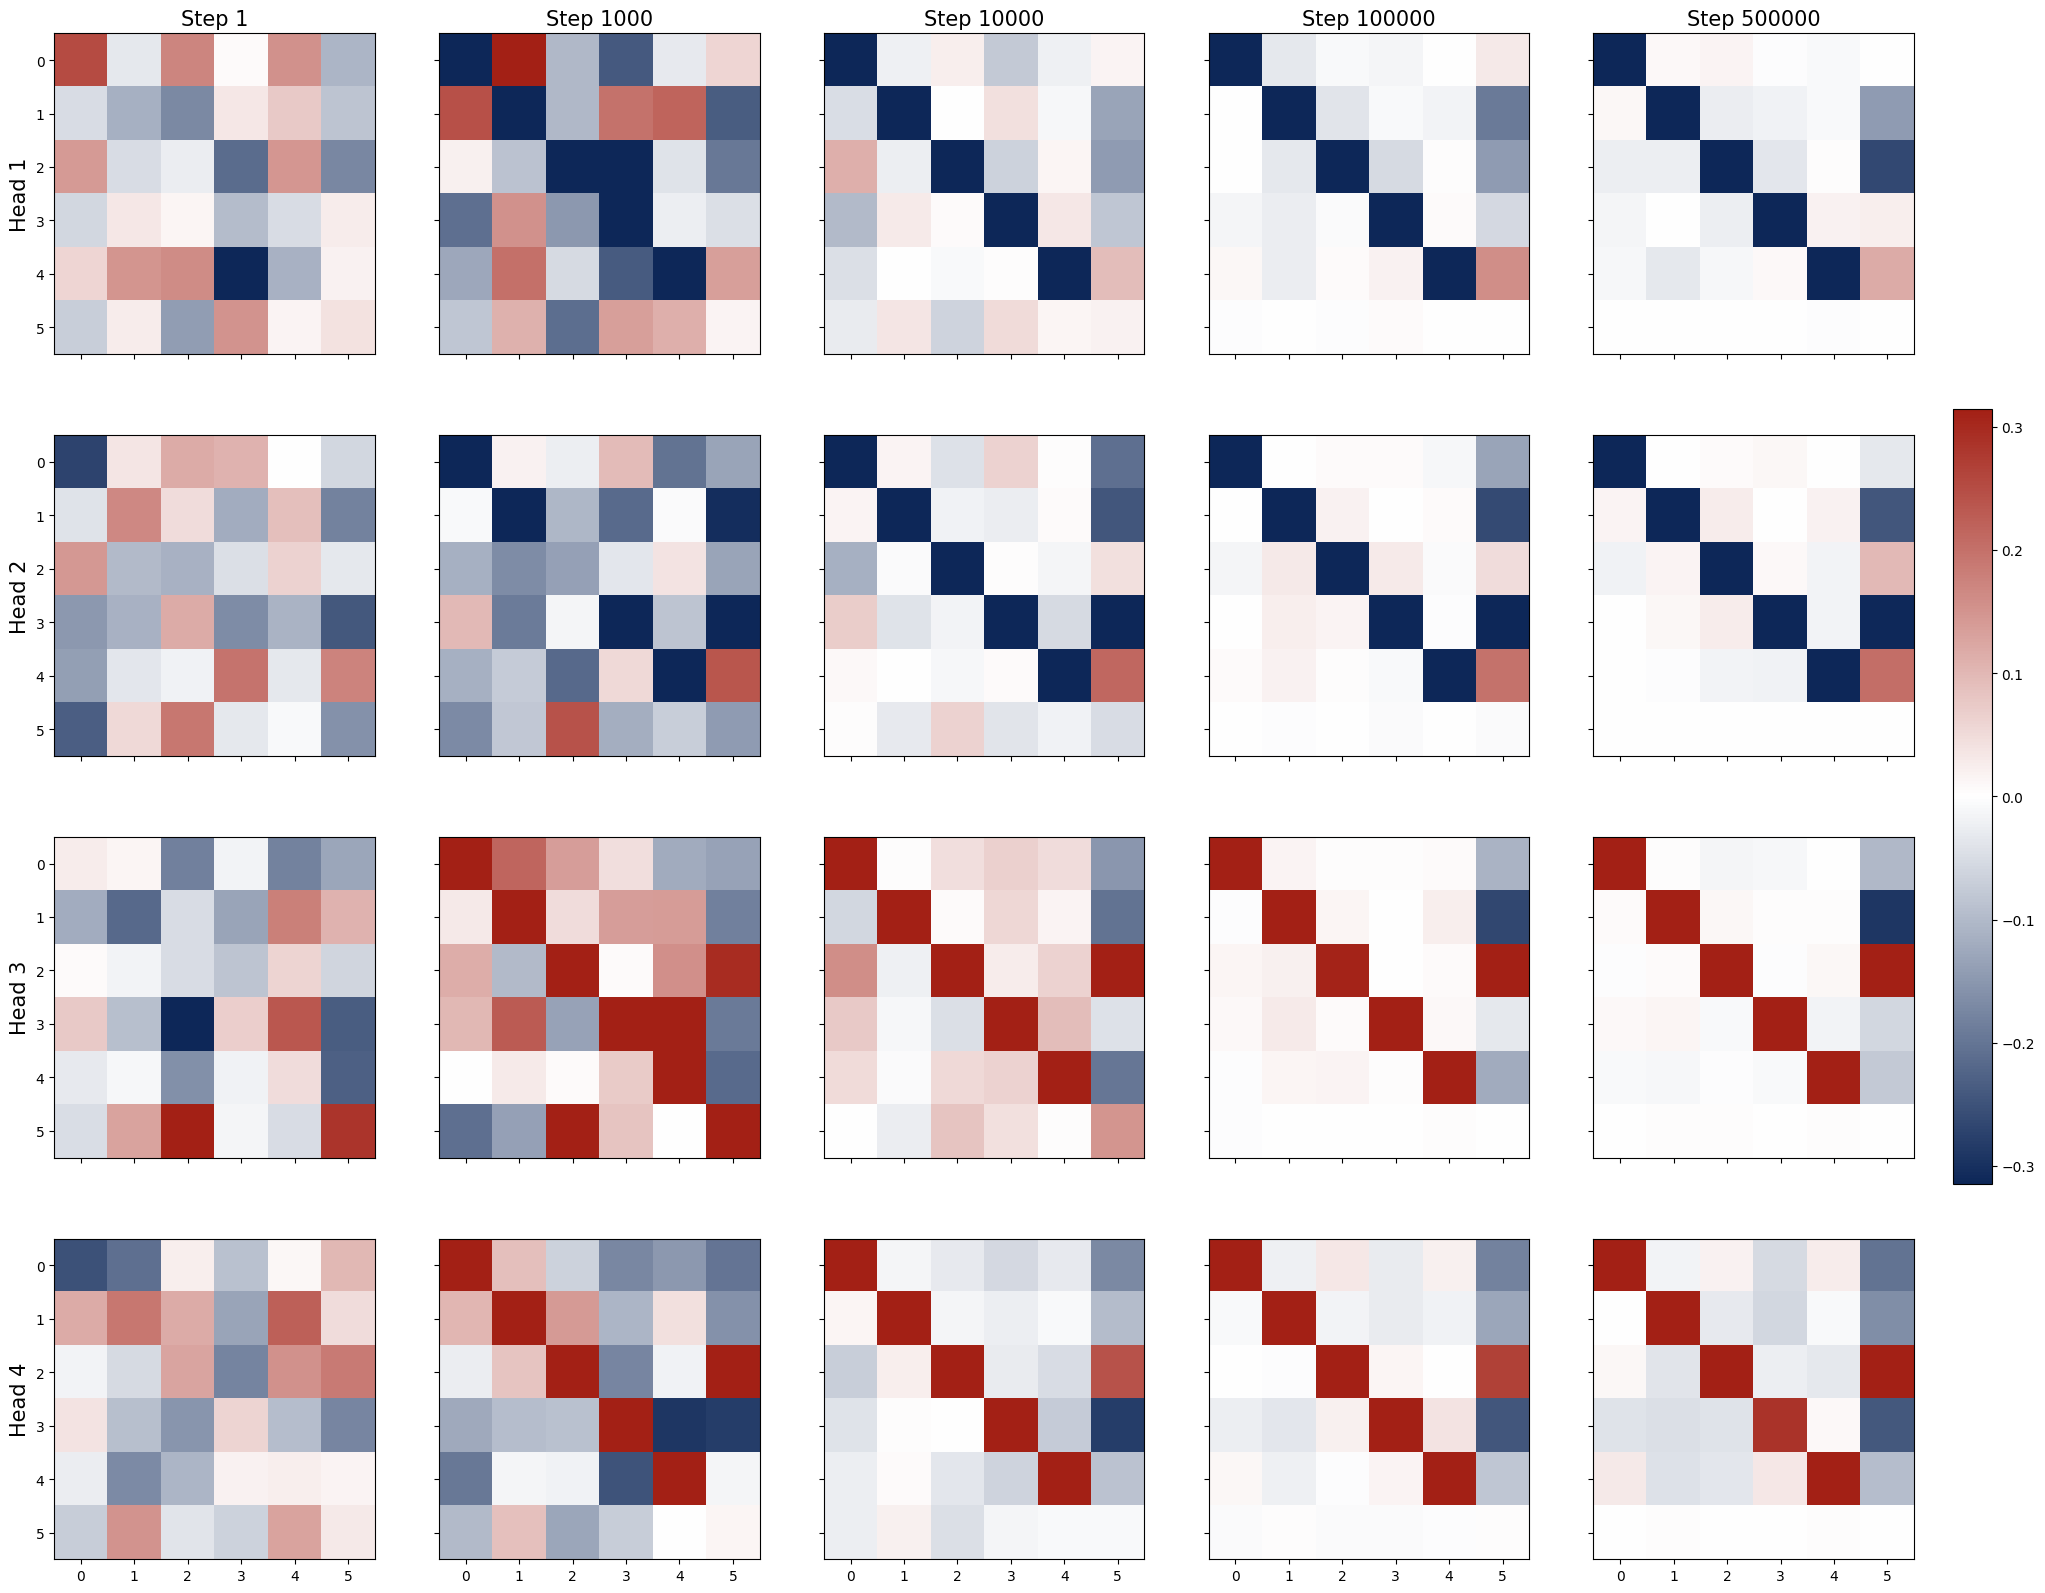

Layer 0, Head 0: w^h = -0.1372, variance of first 5 diagonal elements = 0.0000, sup-norm of rest of d x d block entries = 0.0146
Layer 0, Head 0: mu^h = -1.1908, sup-norm of rest of OV entries = 0.0333
Layer 0, Head 1: w^h = -0.1388, variance of first 5 diagonal elements = 0.0000, sup-norm of rest of d x d block entries = 0.0104
Layer 0, Head 1: mu^h = -2.0372, sup-norm of rest of OV entries = 0.0309
Layer 0, Head 2: w^h = 0.1422, variance of first 5 diagonal elements = 0.0000, sup-norm of rest of d x d block entries = 0.0063
Layer 0, Head 2: mu^h = 2.7210, sup-norm of rest of OV entries = 0.0351
Layer 0, Head 3: w^h = 0.1343, variance of first 5 diagonal elements = 0.0001, sup-norm of rest of d x d block entries = 0.0239
Layer 0, Head 3: mu^h = 0.4412, sup-norm of rest of OV entries = 0.0123

Summary of w^h and mu^h for each head:
Head 0: mu^h = -1.1908, w^h = -0.1372
Head 1: mu^h = -2.0372, w^h = -0.1388
Head 2: mu^h = 2.7210, w^h = 0.1422
Head 3: mu^h = 0.4412, w^h = 0.1343

Hypothe

In [21]:
result = results[2]

plot_losses(result['training_losses'], result['validation_losses'], result['config'].validation_every)

# Extract components from result
config = result['config']
QK_dynamics = result['qk_dynamics']
OV_dynamics = result['ov_dynamics']
QK_matrices = result['qk_matrices']
model = result['model']

dynamic_log_every_step = config.dynamic_log_every_step
qk_log_every_step = config.qk_log_every_step
n_layers = config.n_layers
n_heads = config.n_head
d = config.d

# Plot dynamics
plot_dynamics(QK_dynamics, OV_dynamics, dynamic_log_every_step, n_layers, n_heads)

# Plot QK and OV matrices for each layer
plot_attn_matrices(model.state_dict(), n_layers, d, n_heads, False)

# Plot evolution of QK matrices for each head
plot_heatmap_sequence_all_heads(QK_matrices, [0,1,10,100,500], 500000, 0.35, False)

# Calculate and print statistics
w_h_values, mu_h_values = calculate_statistics(model, d)

[-0.13718386, -0.13878915, 0.14222671, 0.13433658] [-1.1907965, -2.0371623, 2.721042, 0.44122258]


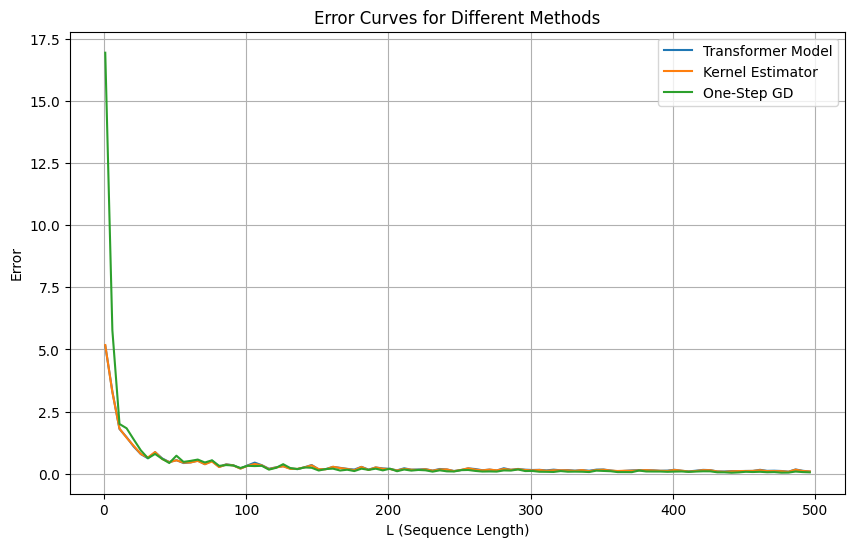

In [22]:
# Assuming `w_h_values` and `mu_h_values` are defined or will be provided
methods = [
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model),
    lambda zs_q, zs: kernel_estimator(zs_q, zs, **{'w_h_values': w_h_values, 'mu_h_values': mu_h_values}),
    gradient_step_estimator
]
method_names = ["Transformer Model", "Kernel Estimator", "One-Step GD"]


print(w_h_values, mu_h_values)


# Evaluate and plot errors
evaluate_errors(methods, method_names, loss_func=F.mse_loss, d=model.d)

#### Visualize $H=8$

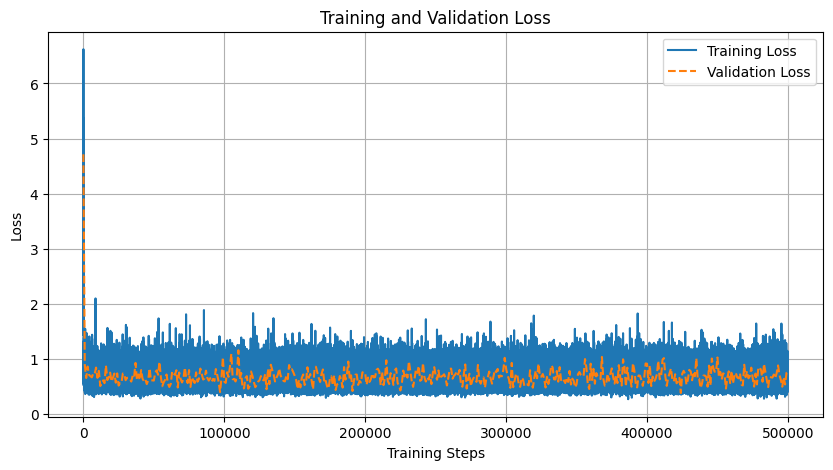

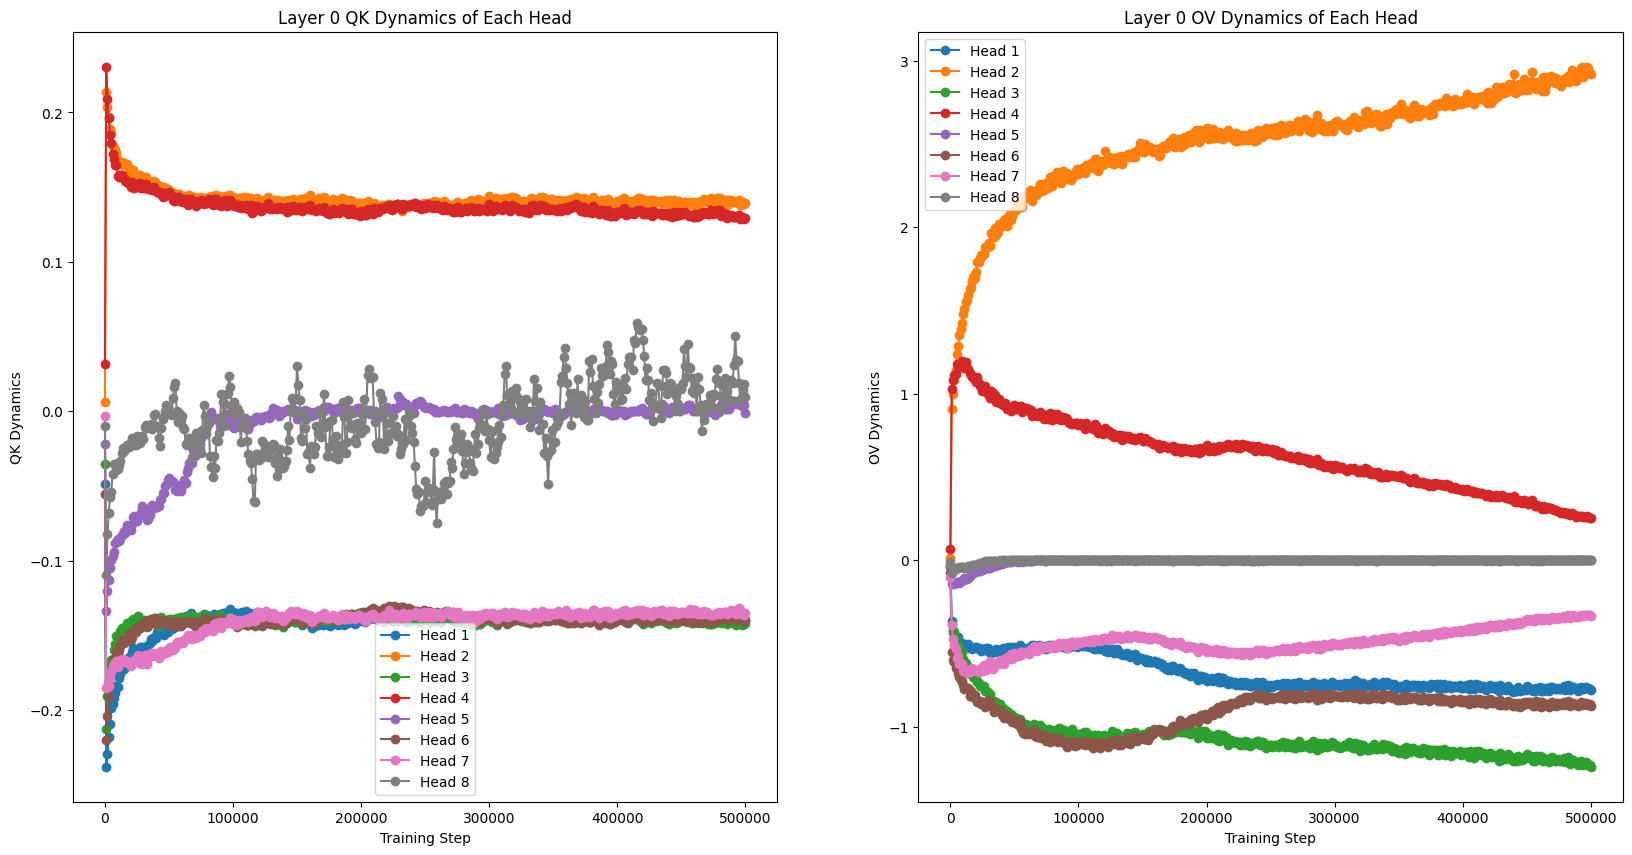

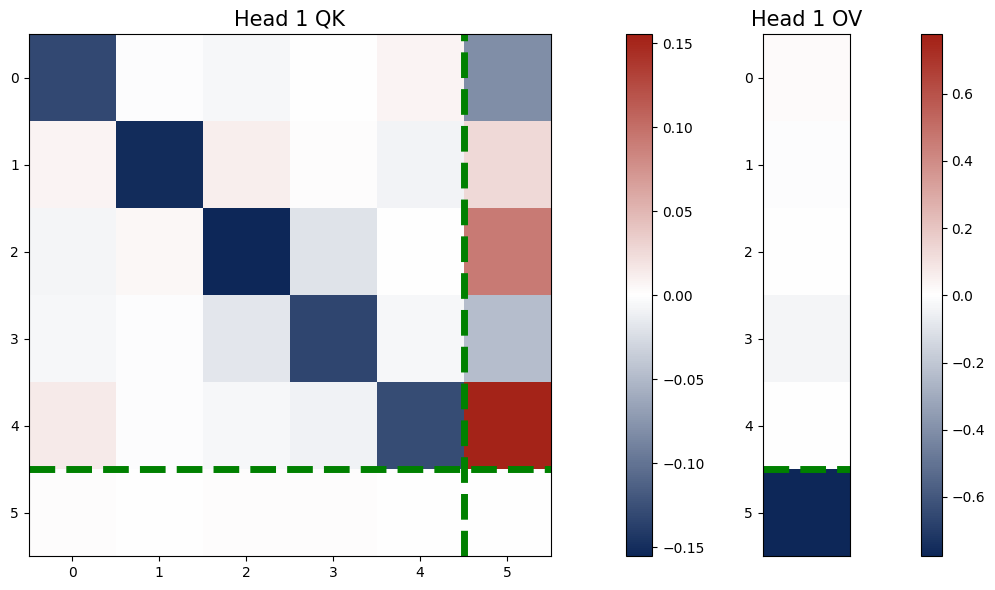

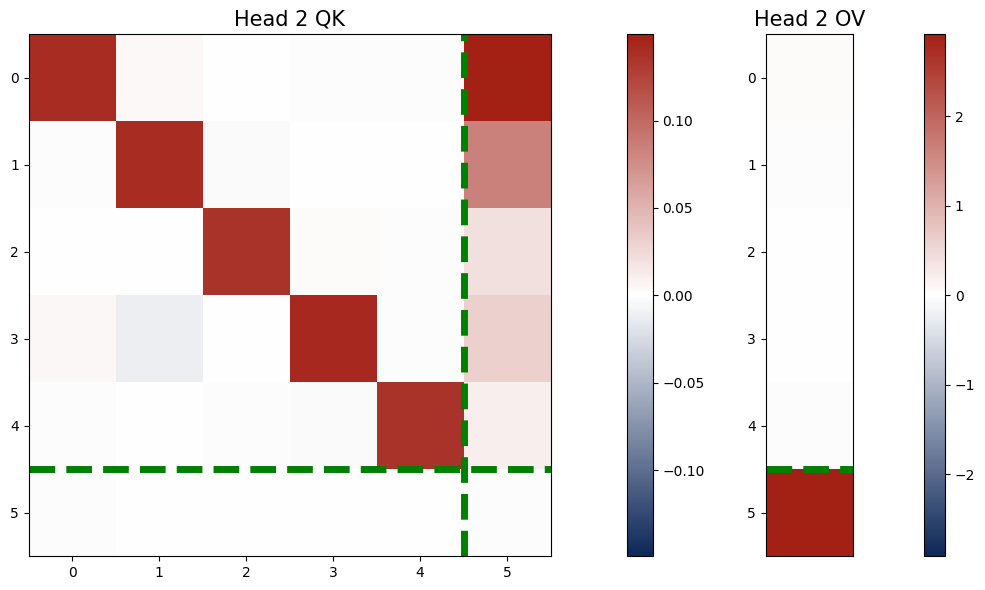

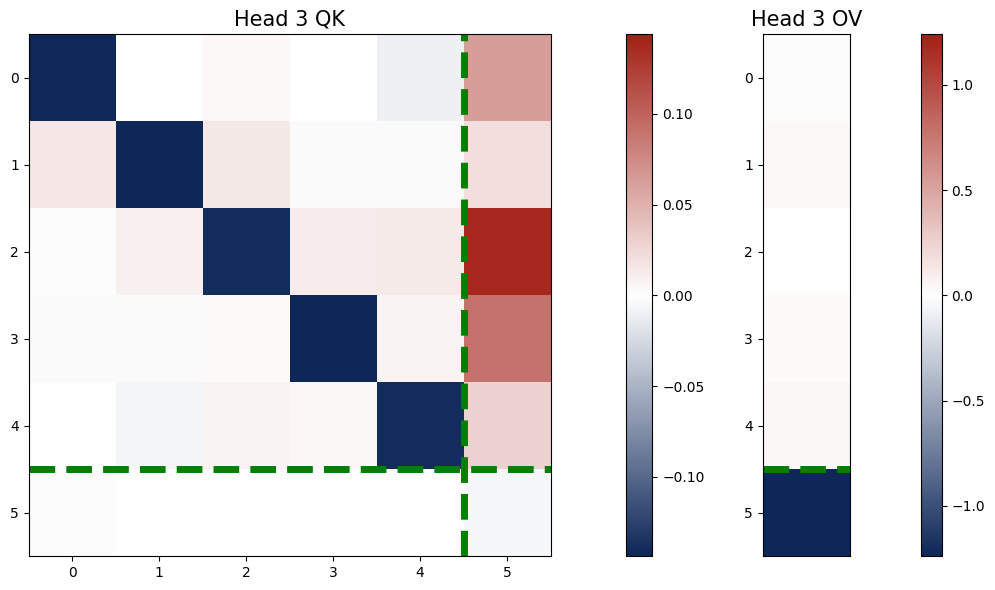

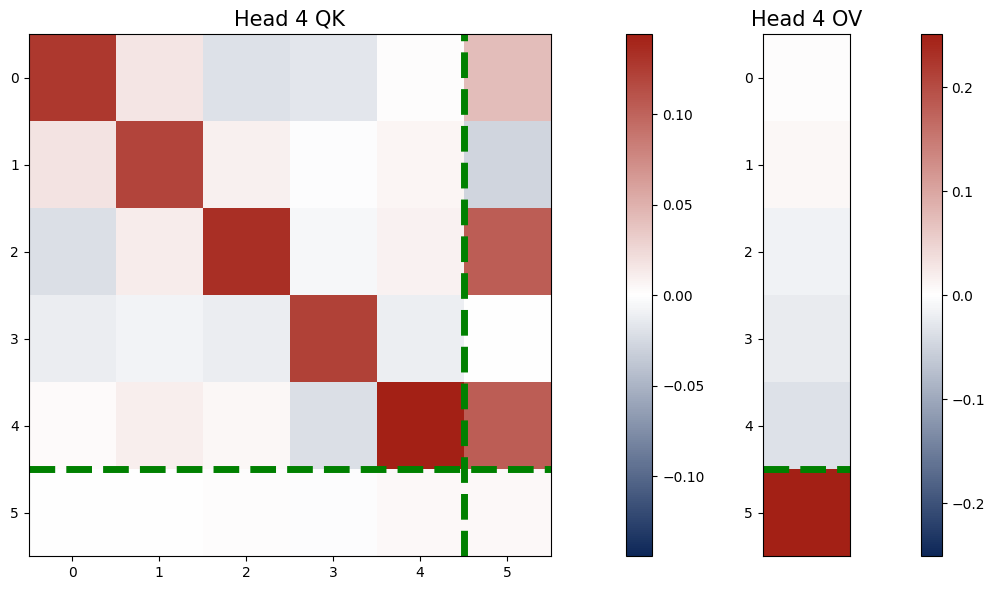

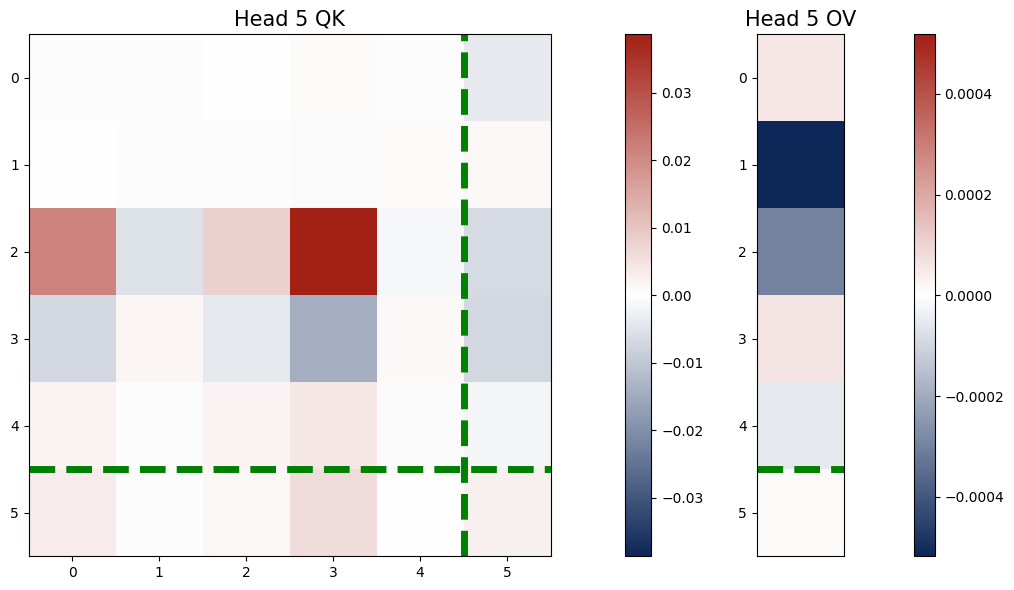

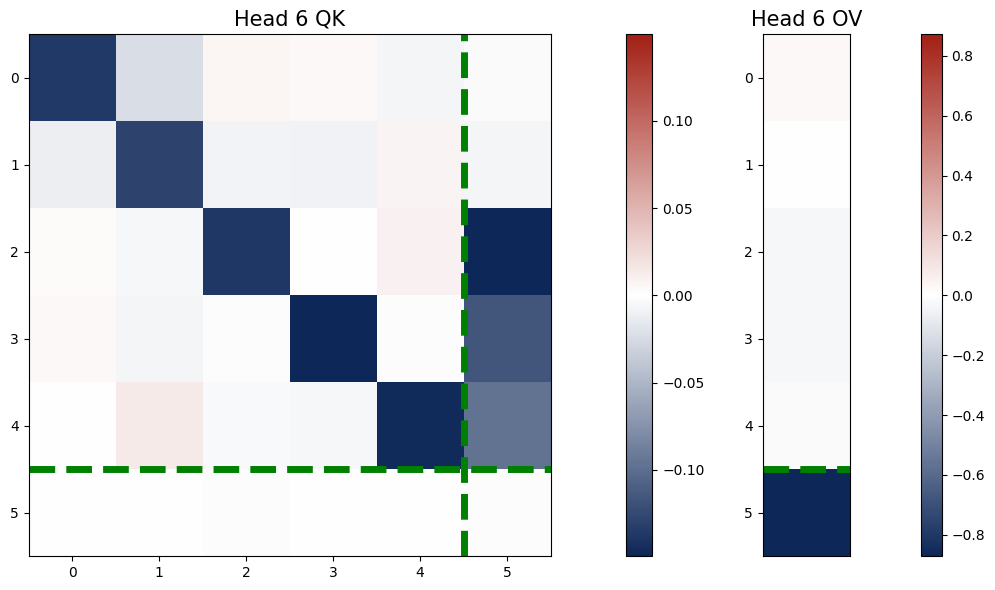

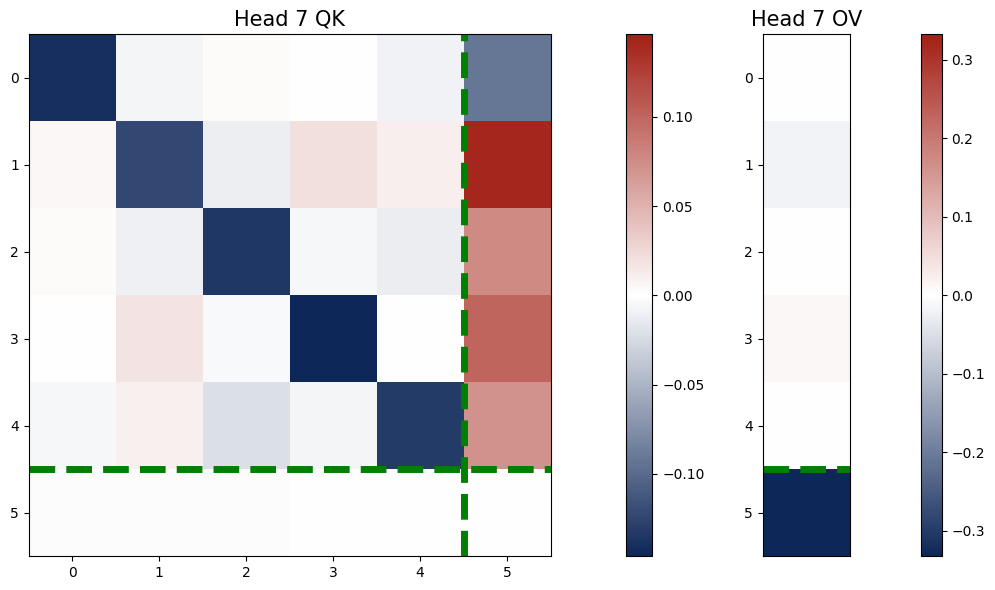

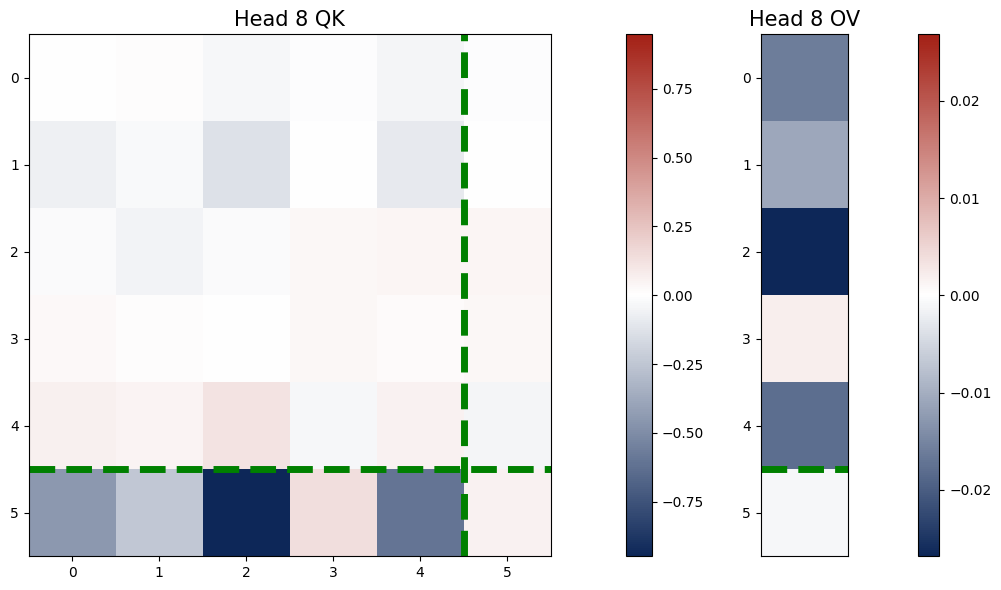

8 501


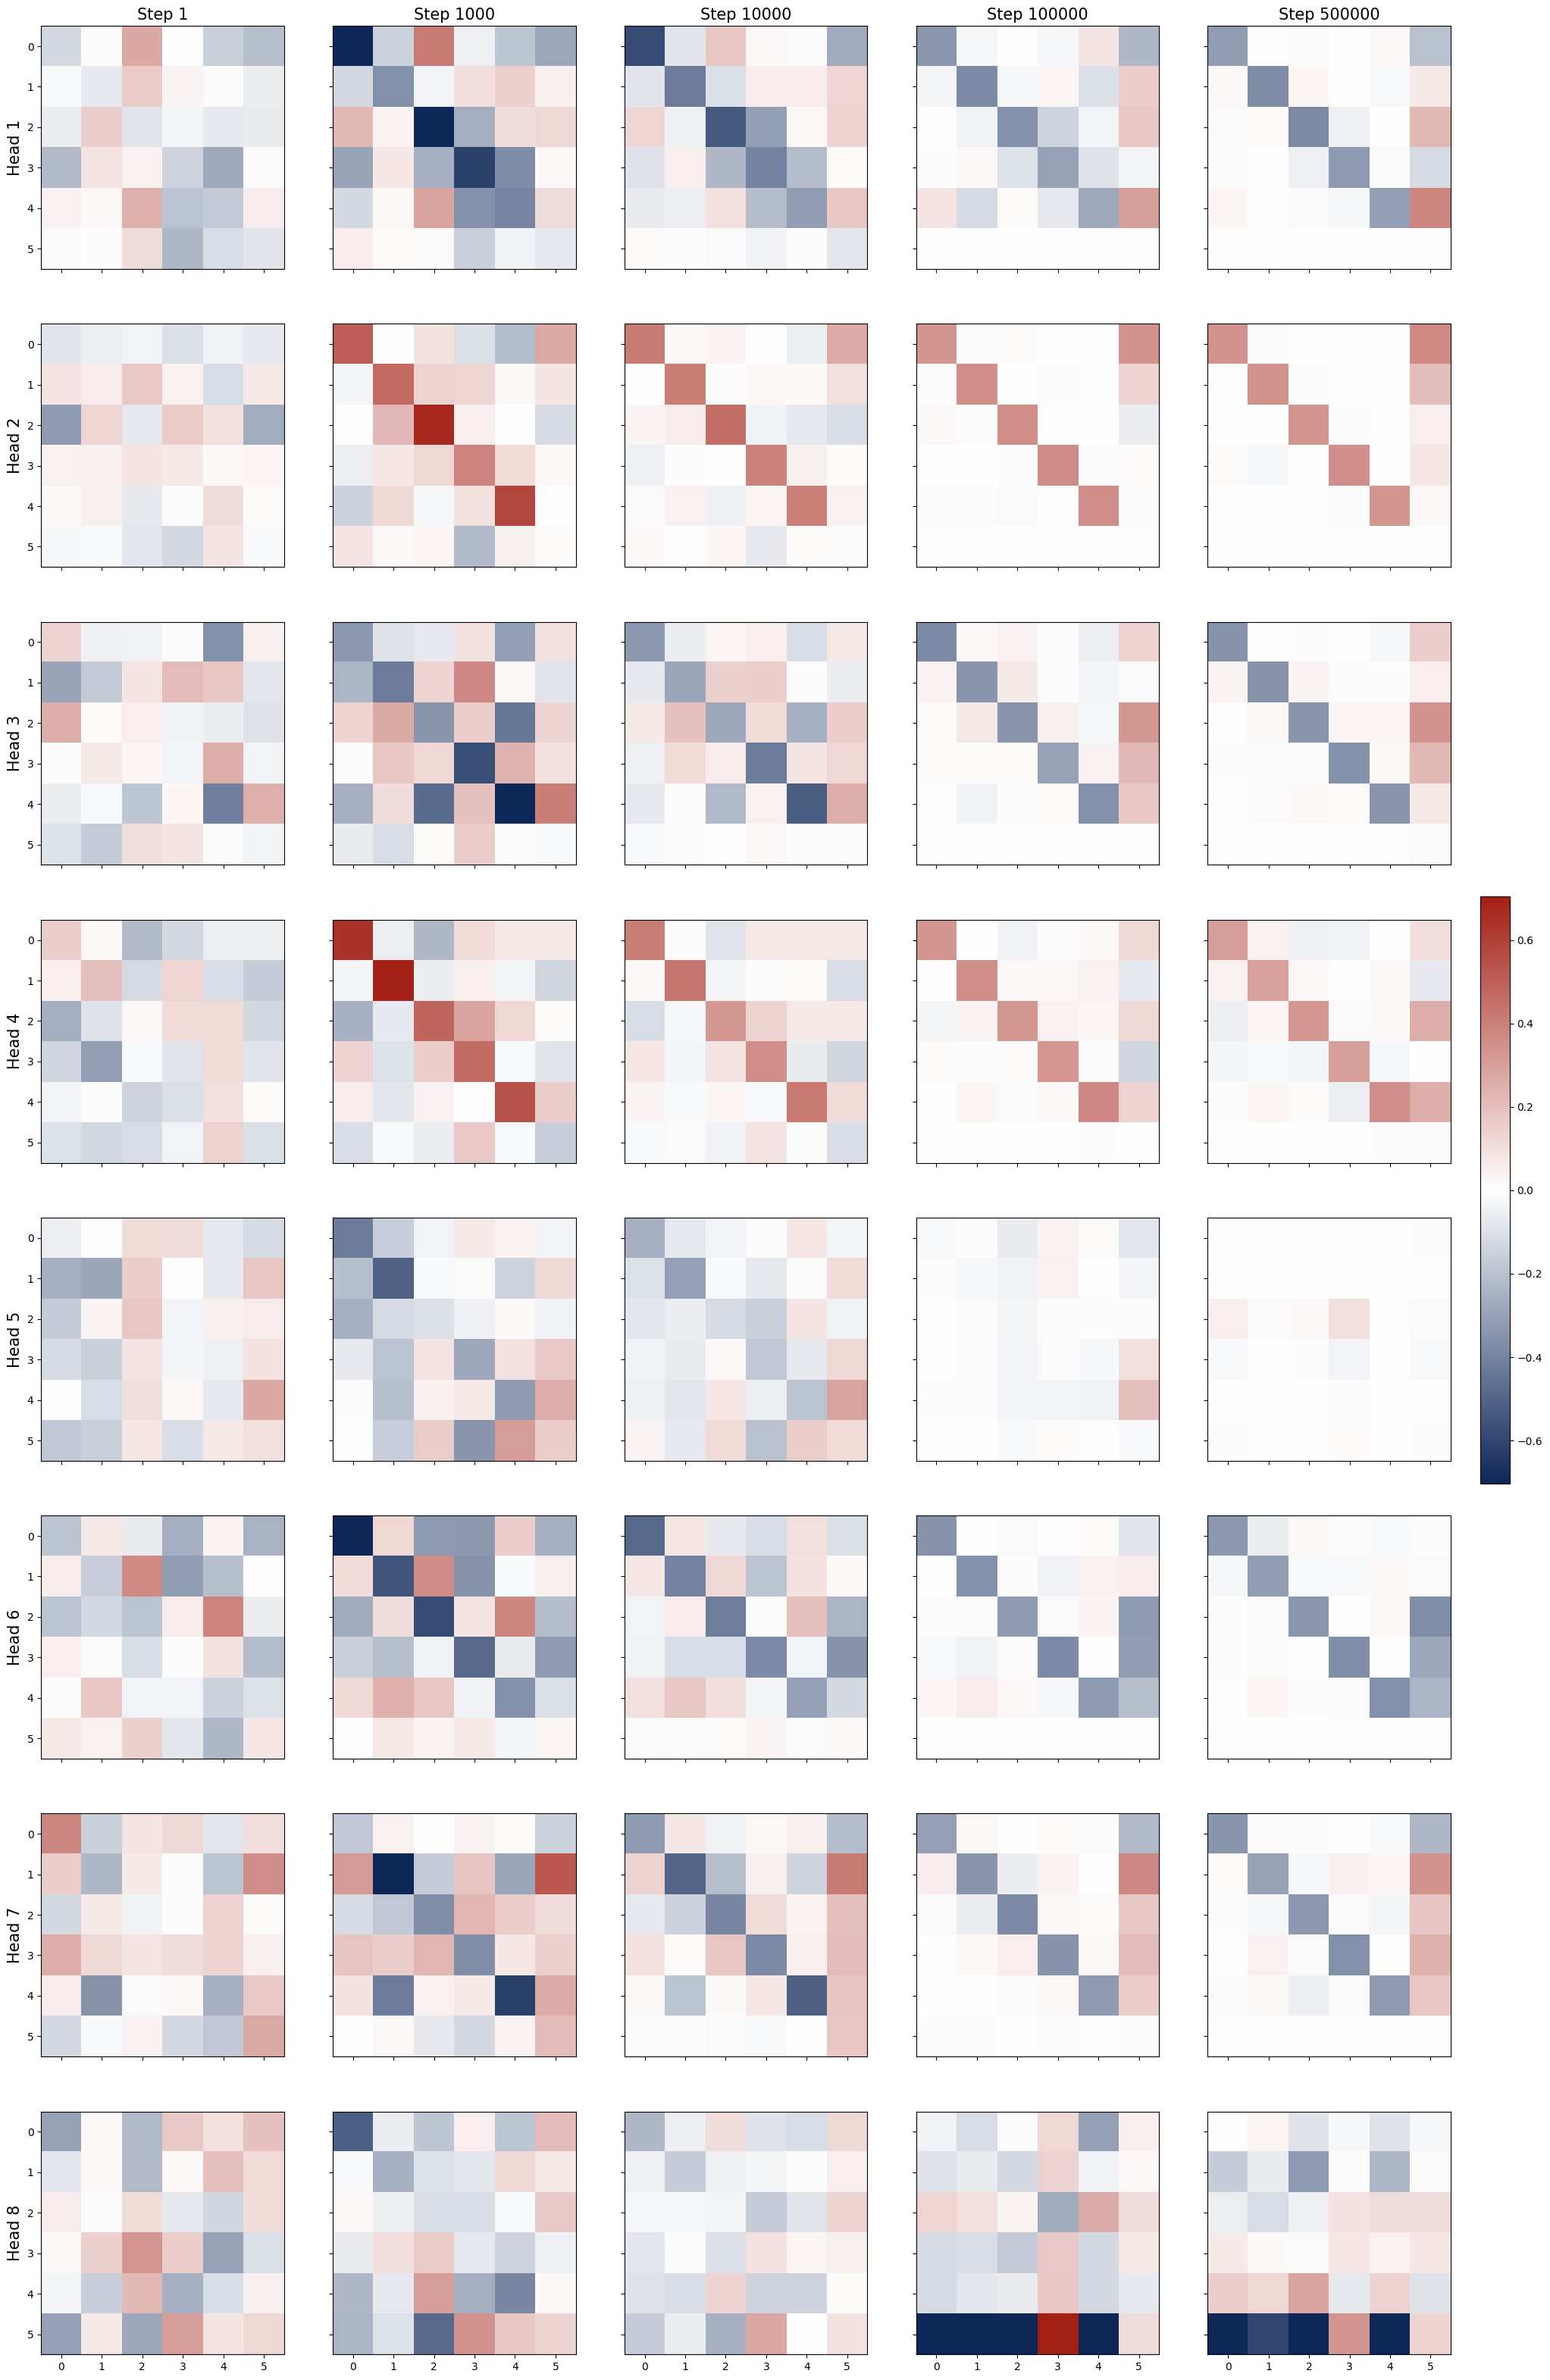

Layer 0, Head 0: w^h = -0.1396, variance of first 5 diagonal elements = 0.0001, sup-norm of rest of d x d block entries = 0.0199
Layer 0, Head 0: mu^h = -0.7766, sup-norm of rest of OV entries = 0.0325
Layer 0, Head 1: w^h = 0.1393, variance of first 5 diagonal elements = 0.0000, sup-norm of rest of d x d block entries = 0.0111
Layer 0, Head 1: mu^h = 2.9165, sup-norm of rest of OV entries = 0.0485
Layer 0, Head 2: w^h = -0.1417, variance of first 5 diagonal elements = 0.0000, sup-norm of rest of d x d block entries = 0.0151
Layer 0, Head 2: mu^h = -1.2395, sup-norm of rest of OV entries = 0.0418
Layer 0, Head 3: w^h = 0.1296, variance of first 5 diagonal elements = 0.0001, sup-norm of rest of d x d block entries = 0.0209
Layer 0, Head 3: mu^h = 0.2509, sup-norm of rest of OV entries = 0.0350
Layer 0, Head 4: w^h = -0.0013, variance of first 5 diagonal elements = 0.0001, sup-norm of rest of d x d block entries = 0.0386
Layer 0, Head 4: mu^h = 0.0000, sup-norm of rest of OV entries = 0.

In [23]:
result = results[3]

plot_losses(result['training_losses'], result['validation_losses'], result['config'].validation_every)

# Extract components from result
config = result['config']
QK_dynamics = result['qk_dynamics']
OV_dynamics = result['ov_dynamics']
QK_matrices = result['qk_matrices']
model = result['model']

dynamic_log_every_step = config.dynamic_log_every_step
qk_log_every_step = config.qk_log_every_step
n_layers = config.n_layers
n_heads = config.n_head
d = config.d

# Plot dynamics
plot_dynamics(QK_dynamics, OV_dynamics, dynamic_log_every_step, n_layers, n_heads)

# Plot QK and OV matrices for each layer
plot_attn_matrices(model.state_dict(), n_layers, d, n_heads, False)

# Plot evolution of QK matrices for each head
plot_heatmap_sequence_all_heads(QK_matrices, [0,1,10,100,500], 500000, 0.35, False)

# Calculate and print statistics
w_h_values, mu_h_values = calculate_statistics(model, d)

[-0.13955215, 0.13931331, -0.14166756, 0.12964724, -0.0012665064, -0.13957725, -0.13503698, 0.009187187] [-0.7766223, 2.9165373, -1.2395257, 0.25088045, 1.1680912e-05, -0.8720298, -0.3324209, -0.0010008902]


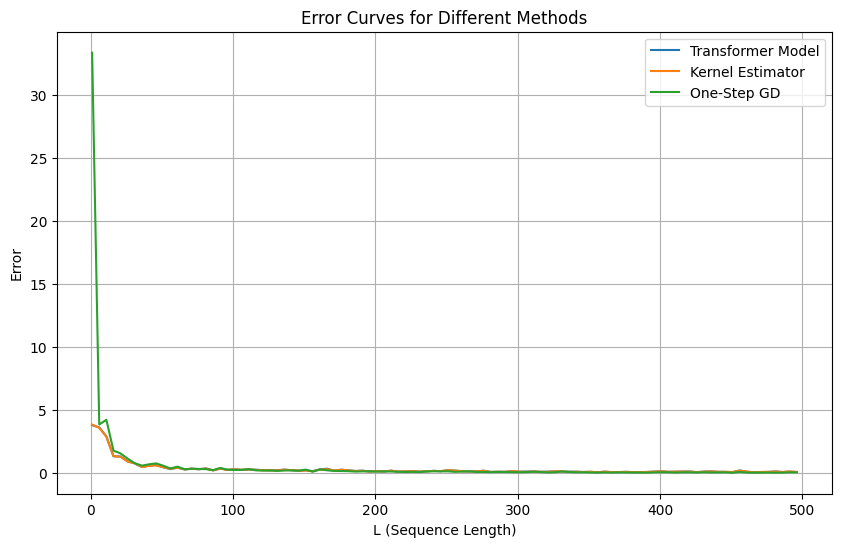

In [24]:
# Assuming `w_h_values` and `mu_h_values` are defined or will be provided
methods = [
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model),
    lambda zs_q, zs: kernel_estimator(zs_q, zs, **{'w_h_values': w_h_values, 'mu_h_values': mu_h_values}),
    gradient_step_estimator
]
method_names = ["Transformer Model", "Kernel Estimator", "One-Step GD"]


print(w_h_values, mu_h_values)


# Evaluate and plot errors
evaluate_errors(methods, method_names, loss_func=F.mse_loss, d=model.d)

## Compare the results of different number of head (including One-Step GD) 

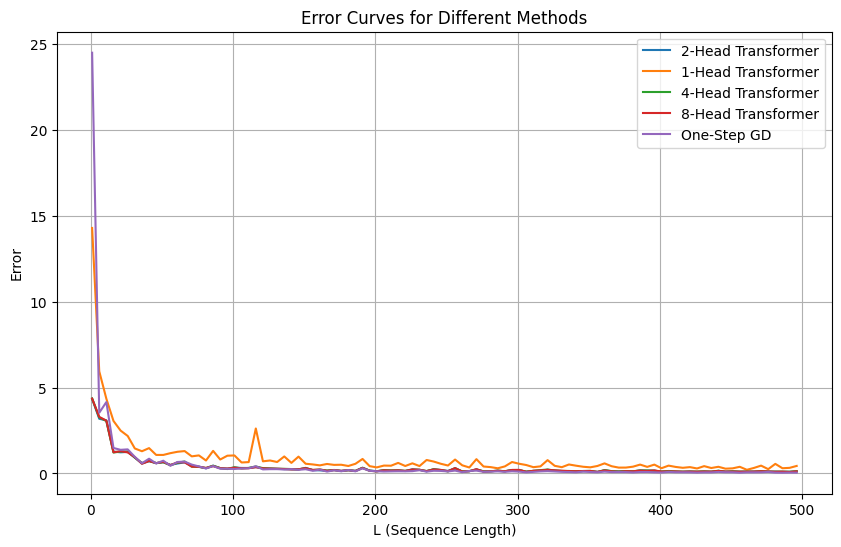

In [25]:
# Assuming models have been pretrained previously
model_1 = results[0]['model'] # Head=2 case
model_2 = results[1]['model'] # Head=1 case
model_3 = results[2]['model'] # Head=4 case
model_4 = results[3]['model'] # Head=8 case
methods = [
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model_1),
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model_2),
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model_3),
    lambda zs_q, zs: transformer_model(zs_q, zs, model=model_4),
    gradient_step_estimator
]
method_names = ["2-Head Transformer", "1-Head Transformer", "4-Head Transformer", "8-Head Transformer", "One-Step GD"]

evaluate_errors(methods, method_names, loss_func=F.mse_loss, d=model.d)

## Analysis of results
1. Multi-Head SoftMax Attention has the same performance as One-Step GD
2. Multi-Head SoftMax Attention outperforms Single-Head SoftMax Attention
3. If the number of head is greater than 2, then **dummy heads** will occur (they does not contribute to output) while **active heads** are equivalent to 2-Head SoftMax Attention.